<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Base/AI_HW4_woodenML_base_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 29 января 23:59

**Продуктивной и интересной вам работы!**

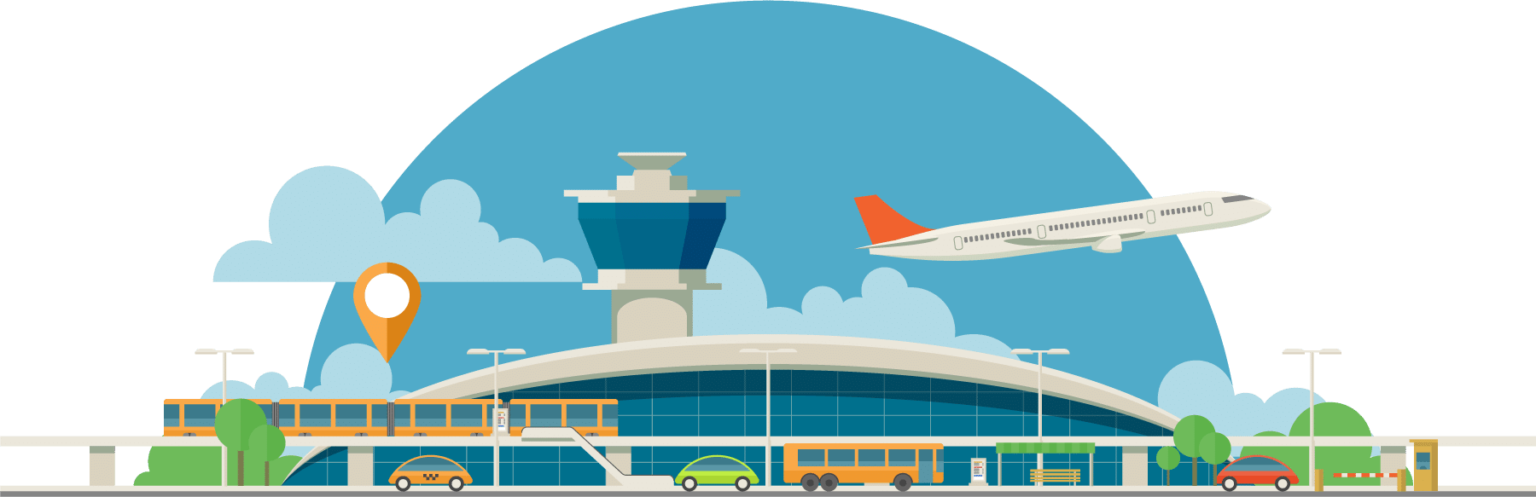

In [8]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
!pip install xgboost
!brew install libomp  # необходимо для XGBoost на macOS
#!pip install lightgbm

  Using cached numpy-2.4.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (6.6 kB)
Using cached numpy-2.4.2-cp313-cp313-macosx_14_0_arm64.whl (5.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-stubs 2.2.3.250308 requires types-pytz>=2022.1.1, which is not installed.
streamlit 1.45.1 requires pandas<3,>=1.4.0, but you have pandas 3.0.0 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.4.2 which is incompatible.
ydata-profiling 4.18.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.8 which is incompatible.
ydata-profiling 4.18.0 requires numpy<2.4,>=1.22, but you have numpy 2.4.2 which is incompatible.
ydata-profiling 4.18.0 requires pandas!=1.4.0,<3.0,>1.5, but

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [10]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2026-02-05 16:32:25--  https://storage.yandexcloud.net/cloud-certs/CA.pem
wget: /Users/slvic/.netrc:4: unknown token "export"
wget: /Users/slvic/.netrc:4: unknown token "GOPRIVATE='gitlab.wildberries.ru/finance'"
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/Users/slvic/.postgresql/root.crt’

/Users/slvic/.postg 100%[===================>]   3.50K  --.-KB/s    in 0s      

2026-02-05 16:32:26 (1.67 GB/s) - ‘/Users/slvic/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

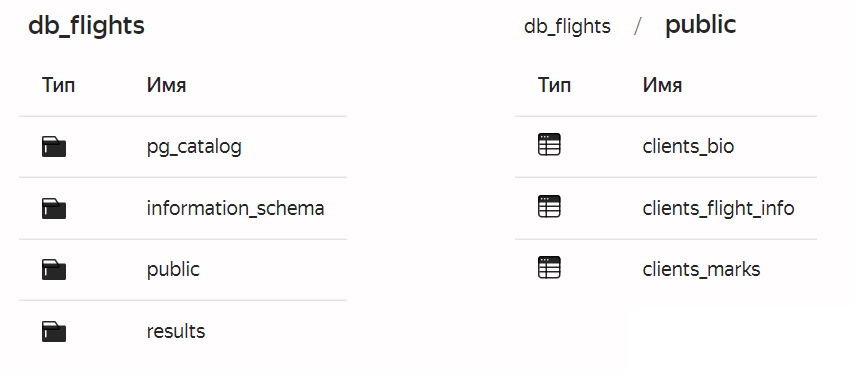



In [11]:
conn_params = dict(
    host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    port=6432,
    dbname="db_flights",
    user="mlhs_student",
    password="mlhs_student",
    sslmode="verify-full",
    target_session_attrs="read-write",
)

# 1) Список столбцов (как у тебя)
cols_sql = """
SELECT table_name, column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'public'
  AND table_name IN ('clients_bio', 'clients_flight_info', 'clients_marks')
ORDER BY table_name, ordinal_position;
"""

with psycopg2.connect(**conn_params) as conn:
    cols_df = pd.read_sql_query(cols_sql, conn)

cols_df


# 2) JOIN трёх таблиц
# Важно: после SELECT b.*, f.*, m.* часто получается несколько колонок 'id'.
# Поэтому либо не тащим id трижды, либо удаляем дубли в pandas.
join_sql = """
SELECT
    b.id,
    b.*,
    f.*,
    m.*
FROM public.clients_bio AS b
JOIN public.clients_flight_info AS f ON f.id = b.id
JOIN public.clients_marks AS m ON m.id = b.id;
"""

with psycopg2.connect(**conn_params) as conn:
    df = pd.read_sql_query(join_sql, conn)

# 3) Убираем дублирующиеся имена колонок (в т.ч. лишние 'id'), затем ставим индекс
df = df.loc[:, ~df.columns.duplicated()]
df = df.set_index("id")

df.head()

/var/folders/36/g8smjd3109dc79mqqyntkgpw0000gn/T/ipykernel_15256/3762581100.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cols_df = pd.read_sql_query(cols_sql, conn)
/var/folders/36/g8smjd3109dc79mqqyntkgpw0000gn/T/ipykernel_15256/3762581100.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(join_sql, conn)


gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [12]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [13]:
# Посмотрим на примеры данных в каждом столбце
print("Примеры значений в каждом столбце:")
for col in df.columns:
    print(f"{col}: {df[col].iloc[:3].tolist()}")
print()

# Определяем категориальные столбцы (которые точно должны остаться строками)
categorical_cols = ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']

# Преобразуем остальные столбцы в float
for col in df.columns:
    if col not in categorical_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Типы данных после преобразования:")
print(df.dtypes)
print()

# Проверка пропусков
print("=" * 50)
print("ПРОВЕРКА ПРОПУСКОВ")
print("=" * 50)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Пропуски': missing, 'Процент': missing_pct})
print(missing_df[missing_df['Пропуски'] > 0])
print(f"\nВсего пропусков: {df.isnull().sum().sum()}")
print()

# Проверка выбросов в числовых признаках (метод IQR)
print("=" * 50)
print("ПРОВЕРКА ВЫБРОСОВ В ЧИСЛОВЫХ ПРИЗНАКАХ (IQR)")
print("=" * 50)
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float', 'int']).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(df)*100:.2f}%)")
print()

# Проверка выбросов в категориальных признаках (редкие значения)
print("=" * 50)
print("ПРОВЕРКА ВЫБРОСОВ В КАТЕГОРИАЛЬНЫХ ПРИЗНАКАХ (< 10%)")
print("=" * 50)
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    value_counts = df[col].value_counts()
    rare_threshold = len(df) * 0.10  # менее 10% - редкие значения
    rare_values = value_counts[value_counts < rare_threshold]
    if len(rare_values) > 0:
        print(f"{col}: {len(rare_values)} редких категорий (< 10%)")
        print(f"  Примеры: {list(rare_values.index[:5])}")
    else:
        print(f"{col}: уникальных значений - {df[col].nunique()}, редких нет")


Примеры значений в каждом столбце:
gender: ['Male', 'Male', 'Female']
age: ['43.0', '24.0', '61.0']
Customer Type: ['Loyal Customer', 'disloyal Customer', 'Loyal Customer']
Type of Travel: ['Business travel', 'Business travel', 'Personal Travel']
class: ['Business', 'Eco', 'Eco']
Flight Distance: ['1963.0', '453.0', '821.0']
Departure Delay in Minutes: ['0.0', '16.0', '0.0']
Arrival Delay in Minutes: ['0.0', '30.0', '0.0']
Inflight wifi service: ['3.0', '2.0', '2.0']
Departure/Arrival time convenient: ['3.0', '2.0', '5.0']
Ease of Online booking: ['3.0', '2.0', '2.0']
Gate location: ['3.0', '4.0', '1.0']
Food and drink: ['5.0', '5.0', '4.0']
Online boarding: ['4.0', '2.0', '1.0']
Seat comfort: ['5.0', '5.0', '5.0']
Inflight entertainment: ['5.0', '5.0', '5.0']
On-board service: ['5.0', '2.0', '5.0']
Leg room service: ['5.0', '4.0', '2.0']
Baggage handling: ['5.0', '4.0', '5.0']
Checkin service: ['4.0', '2.0', '5.0']
Inflight service: ['5.0', '4.0', '5.0']
cleanliness: ['4.0', '5.0', '1

В датафрейме есть 1644 пропуска, а также кандидаты на выбросы в числовых и категориальных признаках.

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

In [14]:
# Matrix пропущенных значений
plt.figure(figsize=(12, 6))
missingno.matrix(df)
plt.title("Matrix пропущенных значений")
plt.tight_layout()
plt.show()

# Столбчатая диаграмма в логарифмической шкале
plt.figure(figsize=(12, 6))
missingno.bar(df, log=True)
plt.title("Столбчатая диаграмма пропусков (логарифмическая шкала)")
plt.tight_layout()
plt.show()


/var/folders/36/g8smjd3109dc79mqqyntkgpw0000gn/T/ipykernel_15256/2521108950.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

/Users/slvic/Library/Python/3.9/lib/python/site-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


Пропуски в данных практически отсутствуют.
Небольшое количество missing values встречается в отдельных числовых столбцах (например , age).
Общая структура данных полная, пропуски не образуют закономерных паттернов.


Также видно, что пропуски отсутствуют в gender и satisfaction. И больше всего пропусков в Arrival Delay in Minutes и age.

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [15]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [16]:
assert df_train.shape == (103_644, 23)

In [17]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [18]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [19]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [20]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [21]:
# Заполнение пропусков наиболее часто встречающимся значением
# Imputer обучается только на train (избегаем data leakage)
# Применяется ко всем данным

from sklearn.impute import SimpleImputer

# Создаем imputer с стратегией "most_frequent" (мода)
imputer = SimpleImputer(strategy='most_frequent')

# Обучаем только на X_train
imputer.fit(X_train)

# Применяем ко всем данным
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
df_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns, index=df_test.index)

# Преобразуем числовые столбцы обратно в float (SimpleImputer возвращает object)
categorical_cols = ['gender', 'Customer Type', 'Type of Travel', 'class']

for col in X_train.columns:
    if col not in categorical_cols:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
        df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

# Проверяем
print("Пропуски после заполнения:")
print(f"X_train: {X_train.isnull().sum().sum()}")
print(f"X_val: {X_val.isnull().sum().sum()}")
print(f"df_test: {df_test.isnull().sum().sum()}")

print("\nТипы данных X_train:")
print(X_train.dtypes)


Пропуски после заполнения:
X_train: 0
X_val: 0
df_test: 0

Типы данных X_train:
gender                                object
age                                  float64
Customer Type                         object
Type of Travel                        object
class                                 object
Flight Distance                      float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Inflight wifi service                float64
Departure/Arrival time convenient    float64
Ease of Online booking               float64
Gate location                        float64
Food and drink                       float64
Online boarding                      float64
Seat comfort                         float64
Inflight entertainment               float64
On-board service                     float64
Leg room service                     float64
Baggage handling                     float64
Checkin service                      float64
Inflight service    

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [22]:
# Основные статистики по числовым столбцам
print("=" * 60)
print("СТАТИСТИКИ ПО ЧИСЛОВЫМ СТОЛБЦАМ")
print("=" * 60)
print(X_train.describe())
print()

# Основные статистики по категориальным столбцам
print("=" * 60)
print("СТАТИСТИКИ ПО КАТЕГОРИАЛЬНЫМ СТОЛБЦАМ")
print("=" * 60)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    print(f"\n{col}:")
    print(f"  Уникальных значений: {X_train[col].nunique()}")
    print(f"  Мода: {X_train[col].mode()[0]}")
    print(f"  Распределение:")
    print(X_train[col].value_counts())


СТАТИСТИКИ ПО ЧИСЛОВЫМ СТОЛБЦАМ
                age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%    

Выводы о распределениях значений признаков:
- Числовые признаки (континуальные):
     - age: возраст пассажиров в среднем около 40 лет, большинство — в диапазоне 27–51, но есть  явные выбросы (0 лет - минимальный возраст и максимальный возраст 544 года).
	 - Flight Distance: большинство рейсов короткие и средние, но есть редкие очень длинные перелеты, из-за них среднее значение выше медианы.
	 - Departure Delay in Minutes: задержка вылета у большинства рейсов отсутствует (медиана 0 минут), но иногда бывают большие задержки, поэтому среднее значение больше и разброс высокий.
	 - Arrival Delay in Minutes: у большинства рейсов задержка прибытия равна 0 минут (медиана 0), но есть выбросы — максимум 11760 минут.




- Категориальные признаки (номинальные):
     - gender: сильно дисбаланса нет. чаще встречается женский пол среди пассажиров.
     - Customer Type: есть дисбаланс. больше всего пассажиров Loyal Customer. есть пропуски.
     - Type of Travel: есть дисбаланс. больше всего business travel. есть пропуски.
     - class: есть дисбаланс. в основном ездят классом business и eco. есть пропущенные значения.





- Ординальные признаки:
     -  Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking : оценки в основном находятся в диапазоне 2–4. Есть выбросы, так как максимум 45, 45 и 28 соответственно.
     - Gate location,  Food and drink, Online boarding имеют оценки, которые в основном лежат в диапозоне 2-4. Есть выбросы: 36,36,32 максимальные значения у признаков соответственно.
     - Seat comfort: оценки в основном находятся в диапазоне 2–5. Есть выбросы (max = 45).
     - Inflight entertainment, On-board service, Leg room service, cleanliness: оценки в основном находятся в диапазоне 2–4. Есть выбросы: 40, 45, 36,45 максимумы соответственно.
     - Baggage handling, Inflight service: оценки в основном находятся в диапазоне 3-5. Есть выбросы: максимальные значения 40 и 36 соответственно.
     -  Checkin service: оценки в основном находятся в диапазоне 3-4. Есть выбросы: максимальное значение 45.


Кратко:
В числовых признаках возраст пассажиров в среднем около 40 лет, а задержки рейсов чаще всего отсутствуют, но встречаются большие выбросы. Категориальные признаки показывают дисбаланс: преобладают Loyal Customer, business travel и классы Business/Eco. Сервисные оценки в основном лежат в диапазоне 2–5, однако присутствуют некорректные значения выше 5, поэтому данные нужно очистить перед построением модели.


### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [23]:
# Удаление строк с выбросами (значения > 0.996-квантиль)
# Квантили вычисляем на train, применяем к train и val

# Числовые столбцы
numeric_cols = X_train.select_dtypes(include=['float64', 'int64', 'float', 'int']).columns

print(f"Размер до удаления выбросов:")
print(f"X_train: {X_train.shape[0]}, X_val: {X_val.shape[0]}")

# Вычисляем 0.996-квантиль для каждого числового столбца на train
quantiles = X_train[numeric_cols].quantile(0.996)

# Создаем маску для train: True если строка НЕ содержит выбросов
mask_train = pd.Series(True, index=X_train.index)
for col in numeric_cols:
    mask_train &= X_train[col] <= quantiles[col]

# Создаем маску для val
mask_val = pd.Series(True, index=X_val.index)
for col in numeric_cols:
    mask_val &= X_val[col] <= quantiles[col]

# Применяем маски
X_train = X_train[mask_train]
y_train = y_train[mask_train]
X_val = X_val[mask_val]
y_val = y_val[mask_val]

print(f"\nРазмер после удаления выбросов:")
print(f"X_train: {X_train.shape[0]}, X_val: {X_val.shape[0]}")
print(f"\nУдалено строк: train - {(~mask_train).sum()}, val - {(~mask_val).sum()}")


Размер до удаления выбросов:
X_train: 72550, X_val: 31094

Размер после удаления выбросов:
X_train: 71395, X_val: 30600

Удалено строк: train - 1155, val - 494


In [24]:
  print(f"0.996-квантиль для age: {X_train['age'].quantile(0.996)}")
  print(f"Максимум age: {X_train['age'].max()}")
  print(f"Значения age > 100:\n{X_train[X_train['age'] > 100]['age'].value_counts()}")

0.996-квантиль для age: 73.0
Максимум age: 80.0
Значения age > 100:
Series([], Name: count, dtype: int64)


In [25]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [26]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [27]:
print("continuous:", continuous_cols)

print("ordinal:", sorted(ordinal_cols))

print("categorical:", categorical_cols)

# быстрые проверки
missing = (set(continuous_cols) | set(ordinal_cols) | set(categorical_cols)) - set(df.columns)
print("missing cols:", missing)

continuous: ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal: ['Baggage handling', 'Checkin service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Food and drink', 'Gate location', 'Inflight entertainment', 'Inflight service', 'Inflight wifi service', 'Leg room service', 'On-board service', 'Online boarding', 'Seat comfort', 'cleanliness']
categorical: ['gender', 'Customer Type', 'Type of Travel', 'class']
missing cols: set()


In [28]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [29]:
def plot_ordinal(cols, df, y):
    """Draws countplots for ordinal columns with target hue"""
    palette = {'neutral or dissatisfied': '#e74c3c', 'satisfied': '#1abc9c'}
    for col in cols:
        plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=df, x=col, hue=y, palette=palette)
        plt.title(f'Распределение порядкового признака: {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.legend(title='Satisfaction', loc='upper right')
        plt.tight_layout()
        plt.show()


In [30]:
def plot_continuous(cols, df, y):
    """Draws histogram and boxplot in one row for continuous columns"""
    palette = {'neutral or dissatisfied': '#e74c3c', 'satisfied': '#1abc9c'}
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Гистограмма
        for val in ['satisfied', 'neutral or dissatisfied']:
            if val in y.values:
                subset = df[y == val][col]
                sns.histplot(subset, kde=True, ax=axes[0], label=val, 
                           color=palette[val], alpha=0.6)
        axes[0].set_title(f'Распределение признака: {col}', fontsize=14)
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel('Частота', fontsize=12)
        axes[0].legend(title='Satisfaction')
        
        # Boxplot с hue
        sns.boxplot(data=df.assign(satisfaction=y), x='satisfaction', y=col, 
                   hue='satisfaction', palette=palette, ax=axes[1], legend=False)
        axes[1].set_title(f'Ящик с усами: {col}', fontsize=14)
        axes[1].set_xlabel('Satisfaction', fontsize=12)
        axes[1].set_ylabel(col, fontsize=12)
        
        plt.tight_layout()
        plt.show()


In [31]:
def plot_categorical(cols, df, y):
    """Draws countplots for categorical columns with target hue"""
    palette = {'neutral or dissatisfied': '#e74c3c', 'satisfied': '#1abc9c'}
    for col in cols:
        plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=df, x=col, hue=y, palette=palette)
        plt.title(f'Распределение категориального признака: {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.legend(title='Satisfaction', loc='upper right')
        plt.xticks(rotation=45 if df[col].nunique() > 4 else 0)
        plt.tight_layout()
        plt.show()


Отрисовка.

Категориальные: ['gender', 'Customer Type', 'Type of Travel', 'class']
Континуальные: ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Порядковые: ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness']


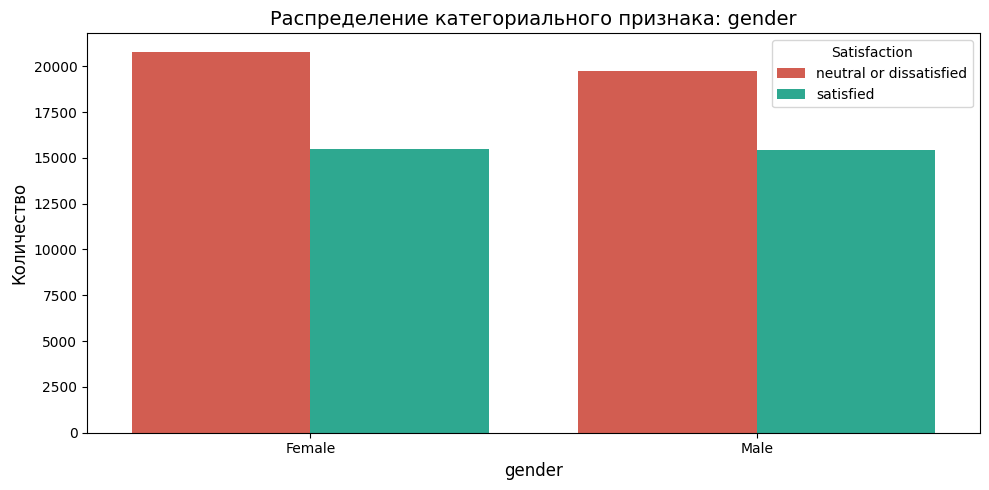

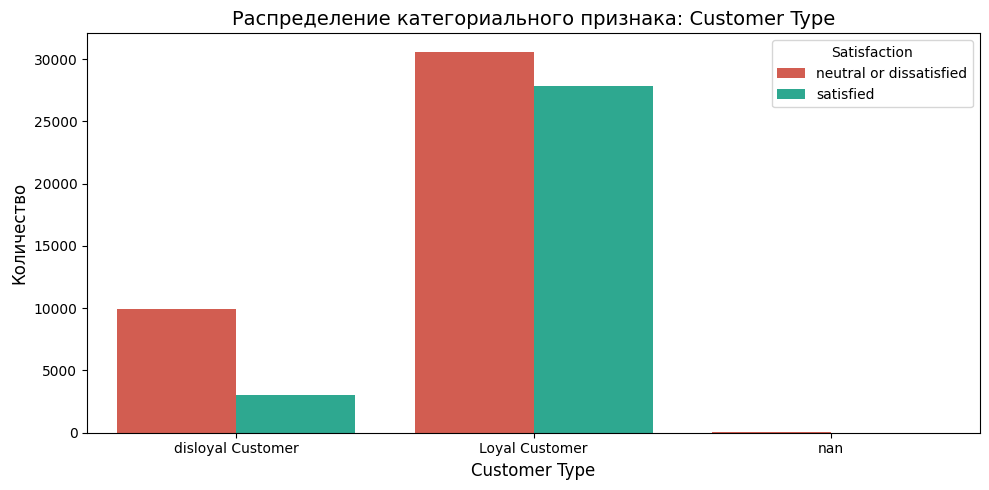

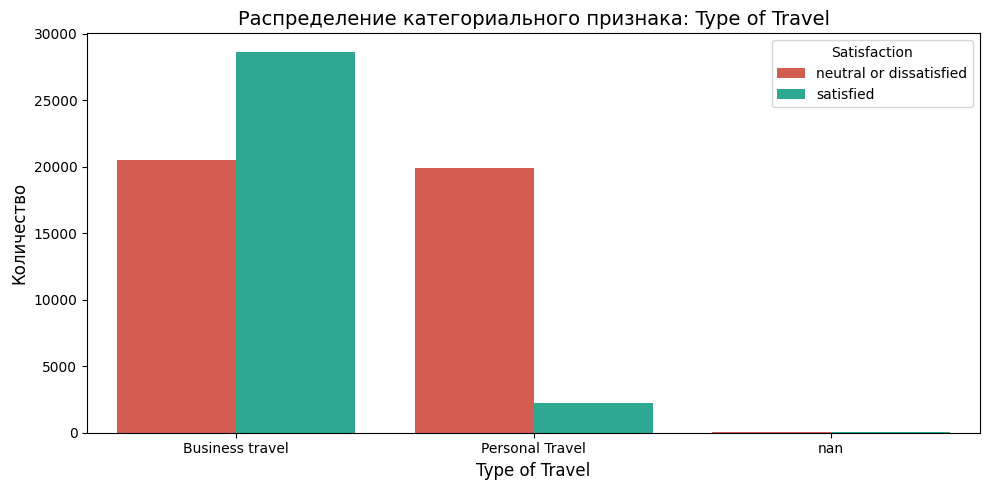

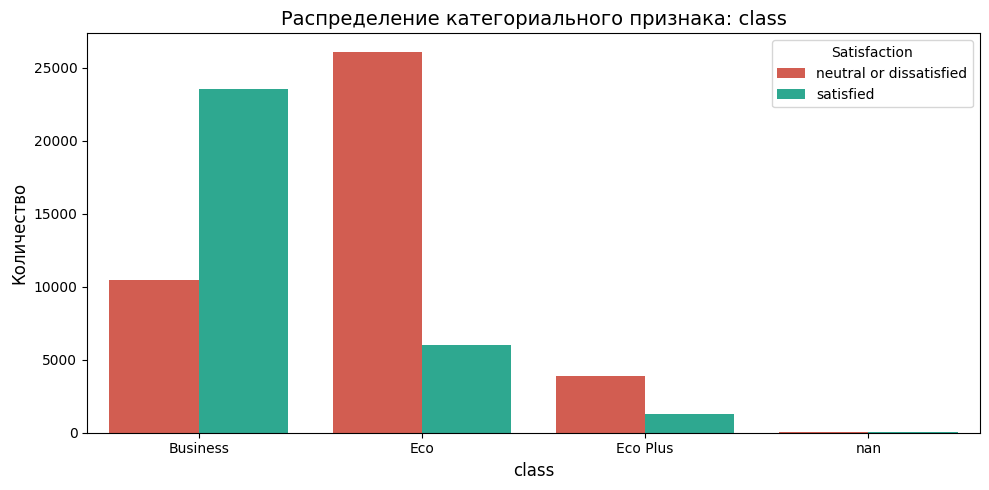

In [32]:
# Определяем типы признаков
categorical_cols = ['gender', 'Customer Type', 'Type of Travel', 'class']

continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

# Порядковые - все остальные числовые столбцы (оценки сервисов)
ordinal_cols = [col for col in X_train.columns 
                if col not in categorical_cols + continuous_cols]

print("Категориальные:", categorical_cols)
print("Континуальные:", continuous_cols)
print("Порядковые:", ordinal_cols)

# Визуализация категориальных признаков
plot_categorical(categorical_cols, X_train, y_train)


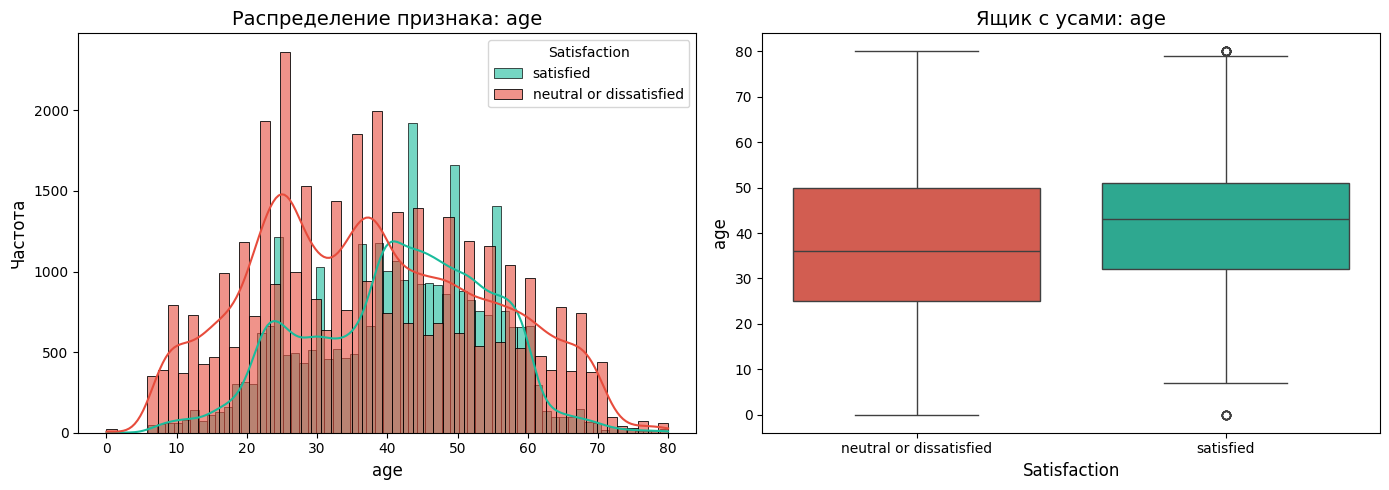

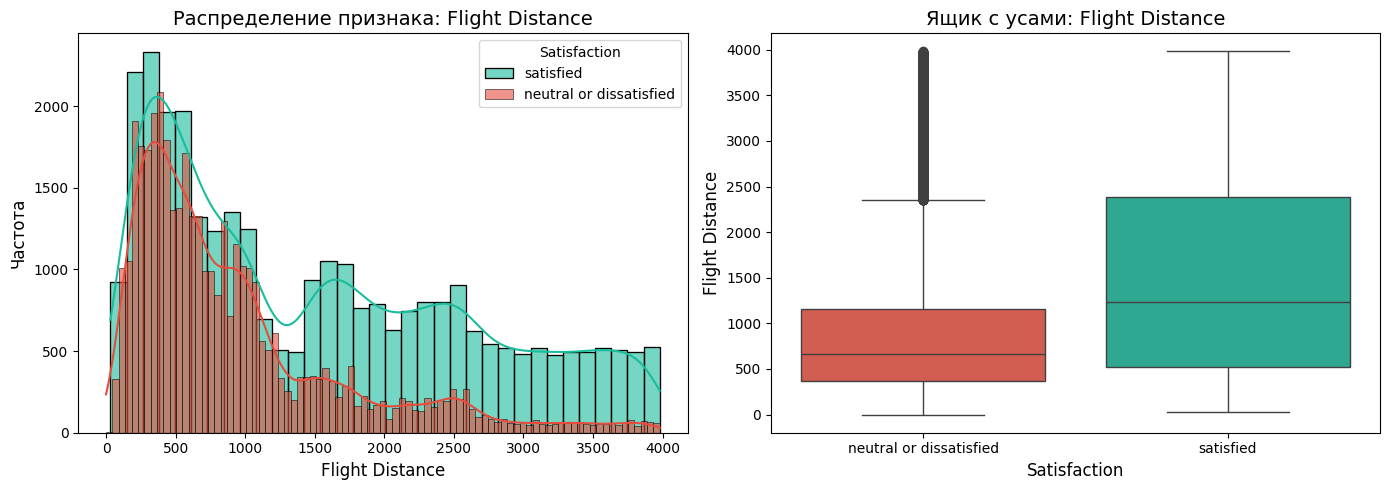

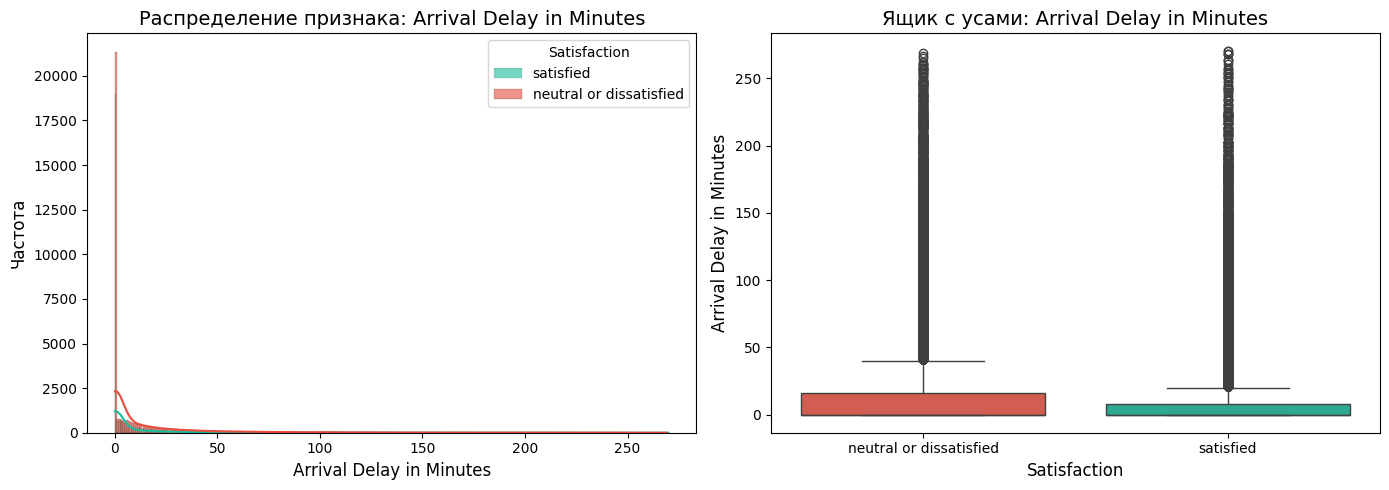

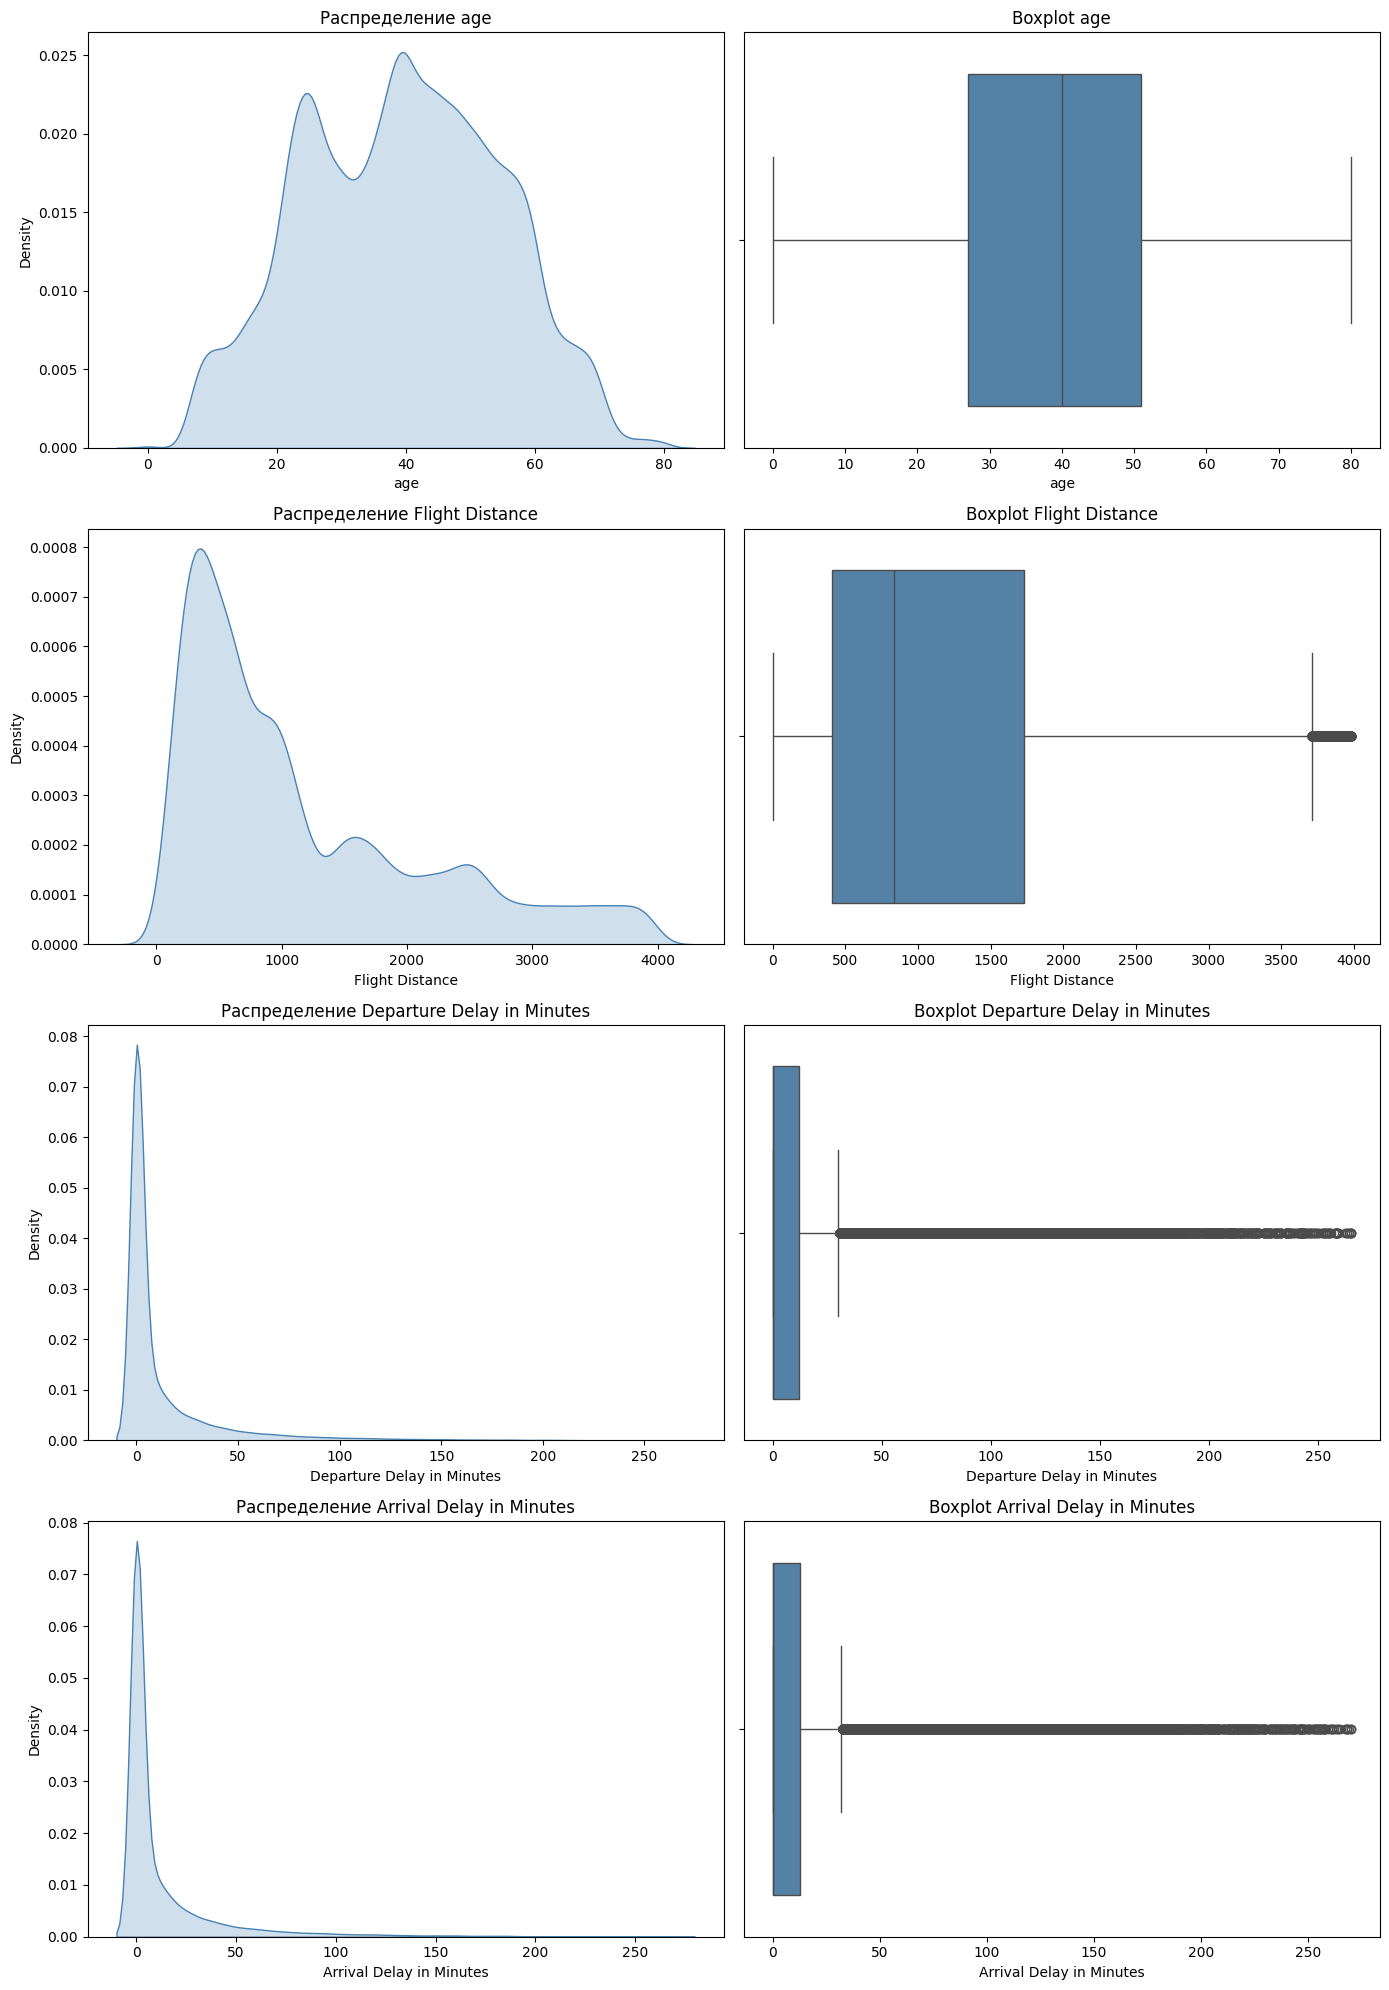

In [33]:

# С разбивкой по таргету
plot_continuous(continuous_cols, X_train, y_train)

# Без таргета - общее распределение
def plot_continuous_no_target(cols, df):
    """Draws kdeplots and boxplots without target split"""
    fig, axes = plt.subplots(len(cols), 2, figsize=(14, 5 * len(cols)))

    for i, col in enumerate(cols):
        sns.kdeplot(data=df, x=col, ax=axes[i, 0], fill=True, color='steelblue')
        axes[i, 0].set_title(f'Распределение {col}')

        # Boxplot
        sns.boxplot(data=df, x=col, ax=axes[i, 1], color='steelblue')
        axes[i, 1].set_title(f'Boxplot {col}')

    plt.tight_layout()
    plt.show()

plot_continuous_no_target(continuous_cols, X_train)

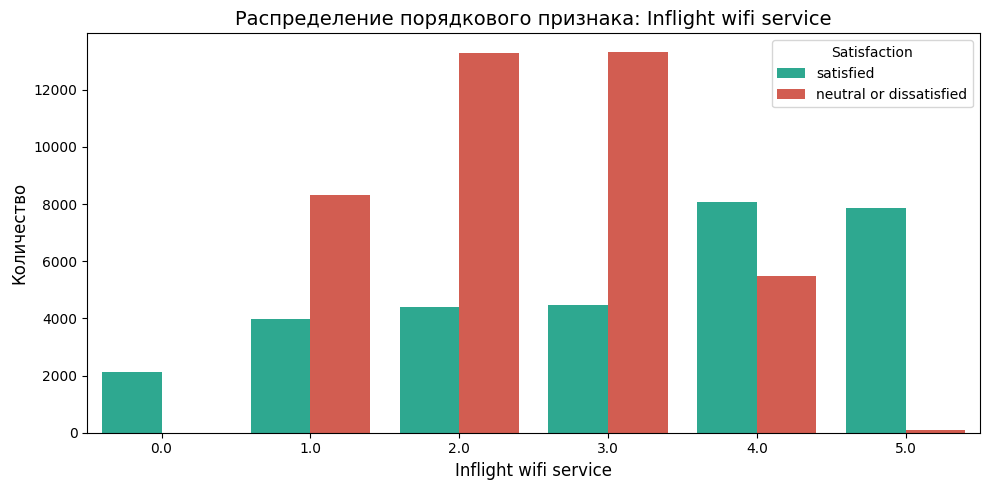

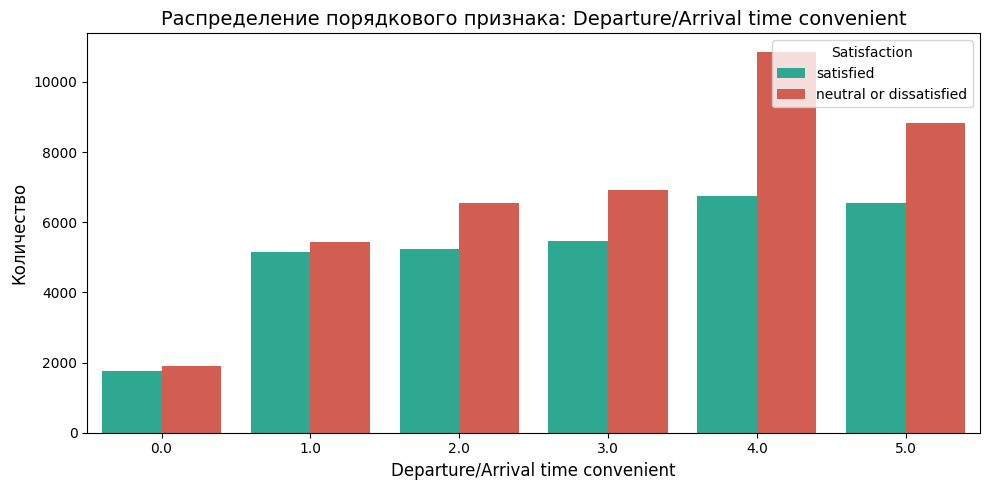

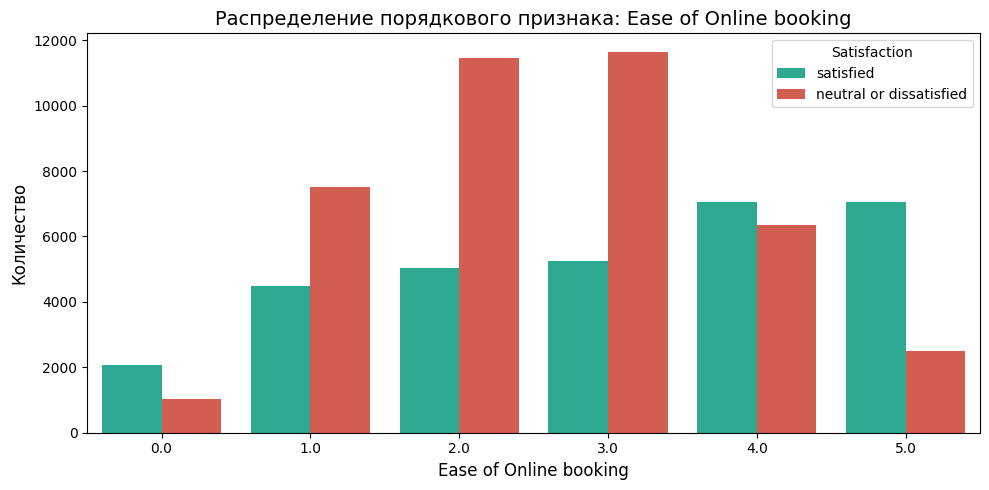

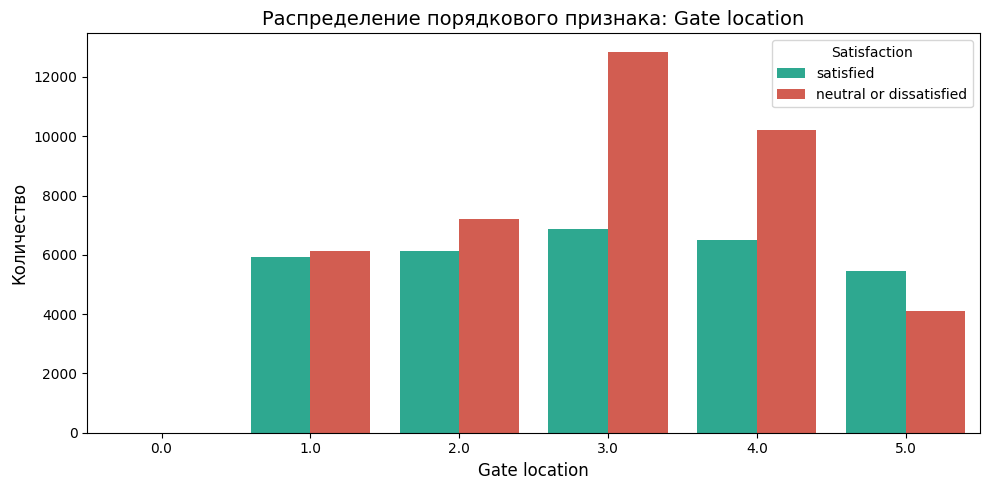

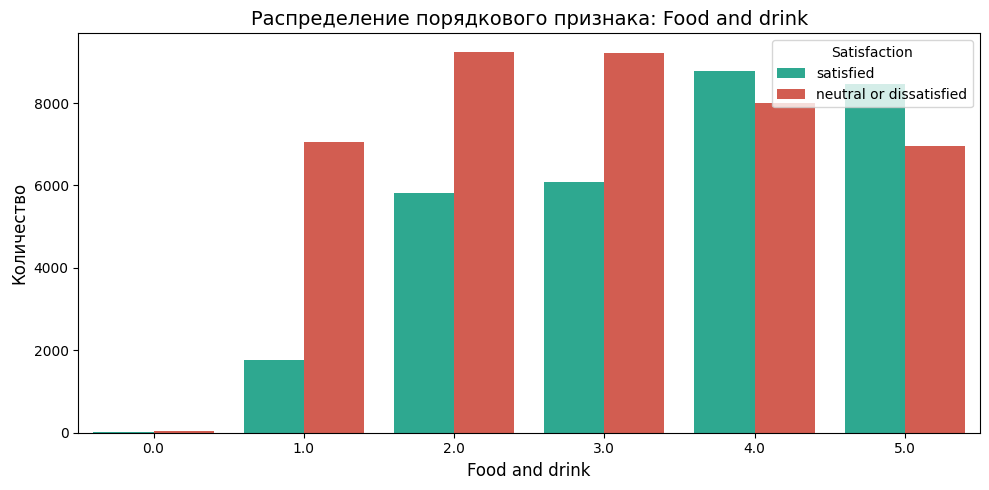

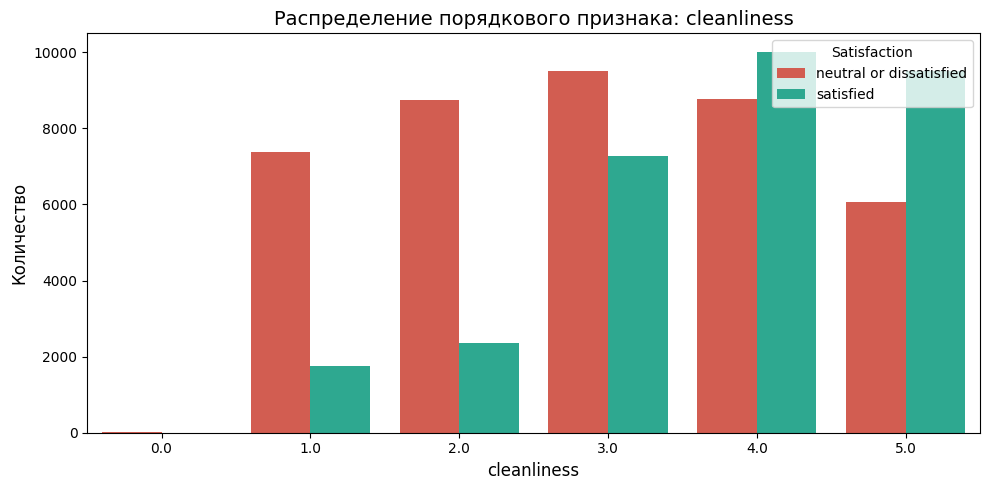

In [34]:
plot_ordinal(ordinal_cols, X_train, y_train)

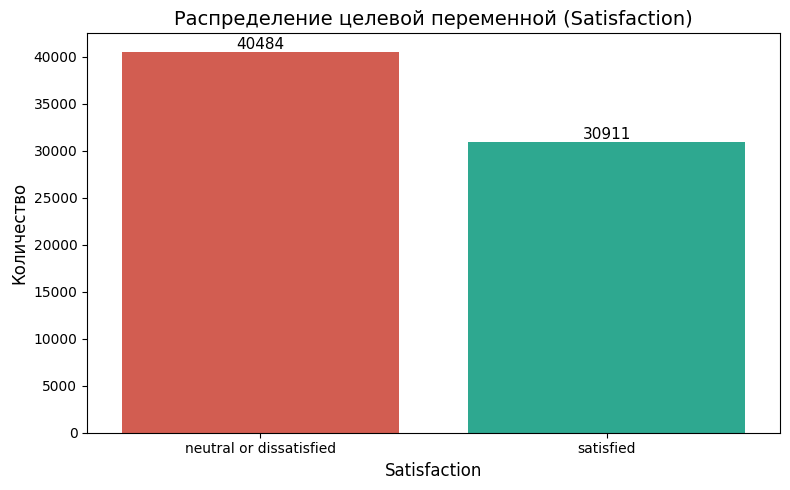

Распределение таргета:
satisfaction
neutral or dissatisfied    56.7
satisfied                  43.3
Name: proportion, dtype: float64


In [35]:
# Визуализация распределения таргета
palette = {'neutral or dissatisfied': '#e74c3c', 'satisfied': '#1abc9c'}

plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y_train, hue=y_train, palette=palette, legend=False)
plt.title('Распределение целевой переменной (Satisfaction)', fontsize=14)
plt.xlabel('Satisfaction', fontsize=12)
plt.ylabel('Количество', fontsize=12)

# Добавляем значения на столбцы
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# Процентное соотношение
print("Распределение таргета:")
print(y_train.value_counts(normalize=True).round(3) * 100)


In [36]:
# Посмотрим на ассиметрию и эксцесс графиков распределения континуальных признаков:

#age
print(f"Асимметрия (Skewness) age: {X_train['age'].skew():.4f}")
print(f"Эксцесс (Kurtosis) age: {X_train['age'].kurtosis():.4f}")

#Flight Distance
print(f"Асимметрия (Skewness) Flight Distance: {X_train['Flight Distance'].skew():.4f}")
print(f"Эксцесс (Kurtosis) Flight Distance: {X_train['Flight Distance'].kurtosis():.4f}")

#Departure Delay in Minutes
print(f"Асимметрия (Skewness) Departure Delay in Minutes: {X_train['Departure Delay in Minutes'].skew():.4f}")
print(f"Эксцесс (Kurtosis) Departure Delay in Minutes: {X_train['Departure Delay in Minutes'].kurtosis():.4f}")

#Arrival Delay in Minutes
print(f"Асимметрия (Skewness) Arrival Delay in Minutes: {X_train['Arrival Delay in Minutes'].skew():.4f}")
print(f"Эксцесс (Kurtosis) Arrival Delay in Minutes: {X_train['Arrival Delay in Minutes'].kurtosis():.4f}")

Асимметрия (Skewness) age: -0.0092
Эксцесс (Kurtosis) age: -0.7055
Асимметрия (Skewness) Flight Distance: 1.1019
Эксцесс (Kurtosis) Flight Distance: 0.2369
Асимметрия (Skewness) Departure Delay in Minutes: 3.6581
Эксцесс (Kurtosis) Departure Delay in Minutes: 16.1542
Асимметрия (Skewness) Arrival Delay in Minutes: 3.6515
Эксцесс (Kurtosis) Arrival Delay in Minutes: 16.1026


### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

Выводы:

- большинство признаков распределены неравномерно. Единственный признак с близким к равномерному распределением — gender. Категориальные признаки Customer Type, Type of Travel и class демонстрируют заметный перекос категорий (доминируют Loyal Customer, Business travel и Eco). Континуальные признаки Flight Distance, Departure Delay и Arrival Delay имеют выраженную правостороннюю асимметрию с длинными хвостами и выбросами; возраст распределён мультимодально и близок к симметричному.
Целевая переменная умеренно сбалансирована (neutral/dissatisfied ~57%, satisfied ~43%). Для большинства порядковых оценок сервиса наблюдается сильная зависимость от таргета: удовлетворенные пассажиры чаще ставят 4–5, а неудовлетворённые — 1–3, что указывает на высокую предсказательную силу этих признаков.


- Признаки, которые распределены равномерно:
    - gender

- Признаки, которые распределены неравномерно:
    - Customer Type;
    - Type of Travel;
    - class;
    - age;
    - Flight Distance;
    - Departure Delay in Minutes
    - Arrival Delay in Minutes;
    - Inflight wifi service;
    - Departure/Arrival time convenient;
    - Ease of online booking;
    - Gate location;
    - Food and drink;
    - Online boarding;
    - Seat comfort;
    - Inflight entertainment;
    - On-board service;
    - Leg room service;
    - Baggage handling;
    - Checkin service;
    - Inflight service;
    - cleanliness.

- Сбалансированность классов:
классы умеренно сбалансированы (neutral or dissatisfied ~ 57%, satisfied - 43%).

- Распределения континуальных признаков:
    - age: мультимодальное распределение с двумя выраженными пиками примерно в области 25 и 40–45 лет, что указывает на наличие нескольких возрастных групп пассажиров. распределение симметрично ((Skewness) age: -0.0092).
    - Flight Distance: ассиметричное распределение с сильным смещением вправо. Те большинство полетов короткие.
    - Departure Delay in Minutes: ассиметричное распределение с сильным смещением вправо. Большинство рейсов имеют нулевую или небольшую задержку, однако присутствуют редкие случаи крупных задержек, формирующие длинный правый хвост.
    - Arrival Delay in Minutes: ассиметричное распределение с сильным смещением вправо. Большинство значений сосредоточено около нуля, однако присутствуют редкие случаи крупных задержек.

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

                            train       val
satisfaction                               
neutral or dissatisfied  0.567043  0.568268
satisfied                0.432957  0.431732


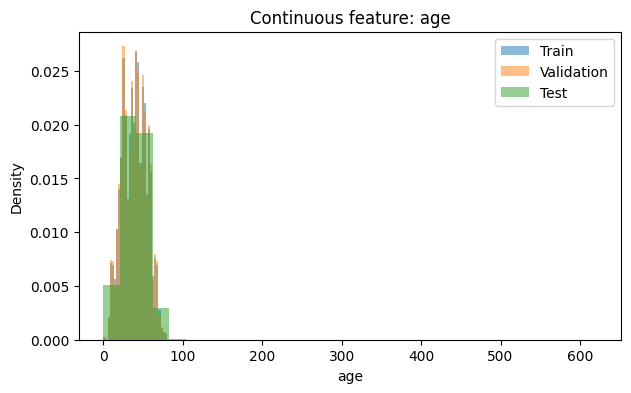

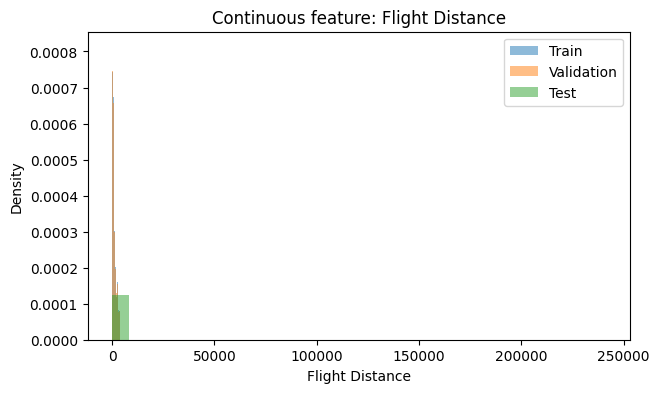

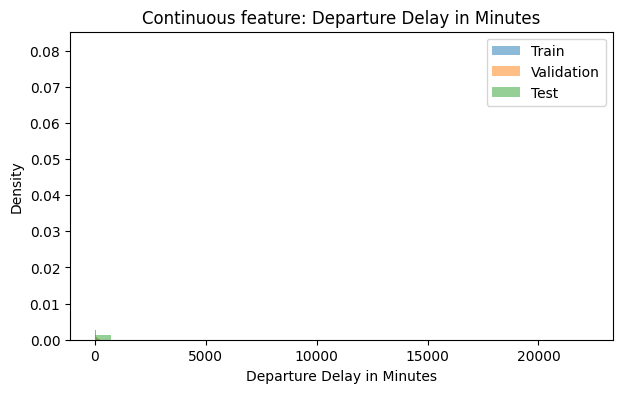

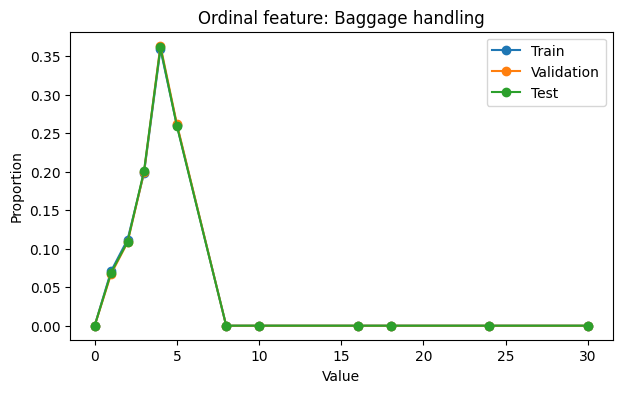

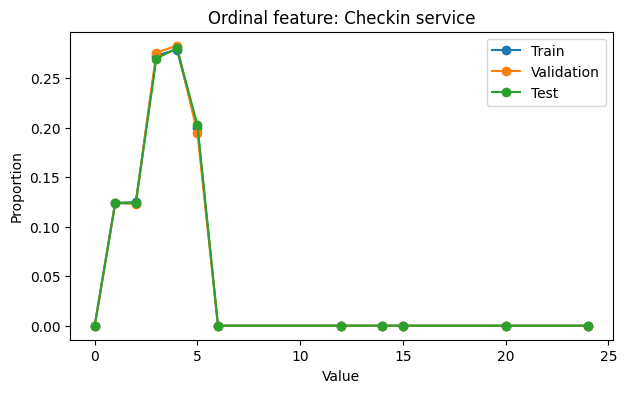

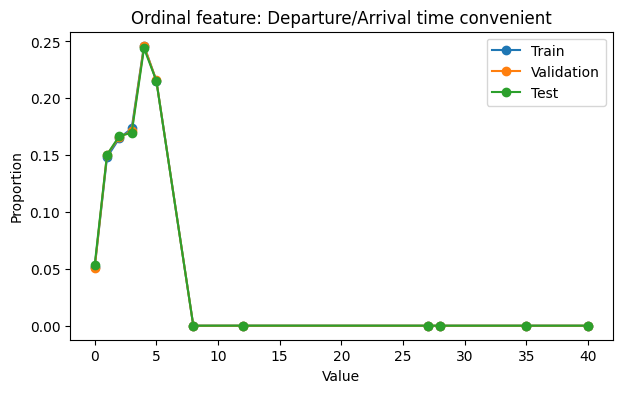

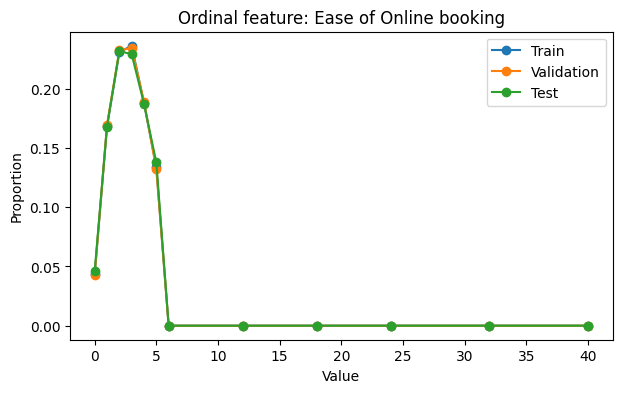

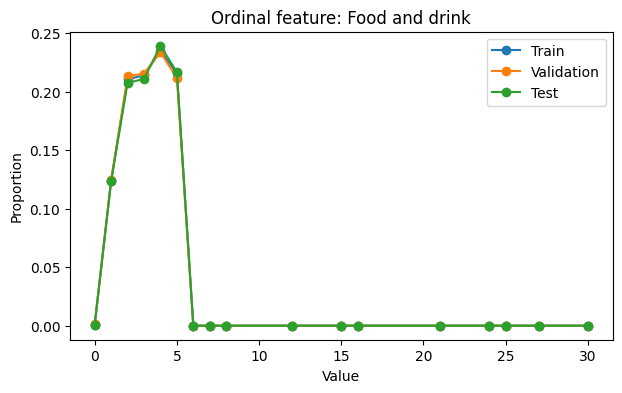

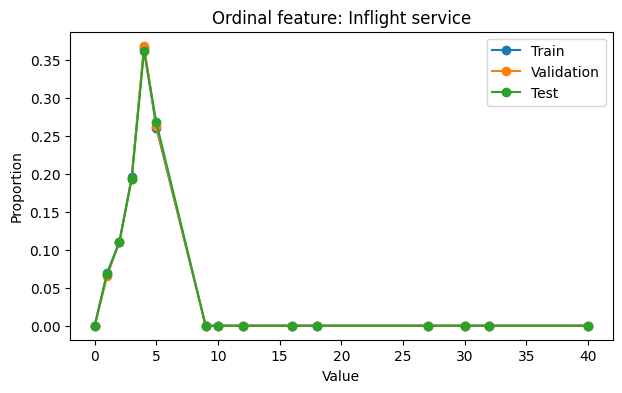

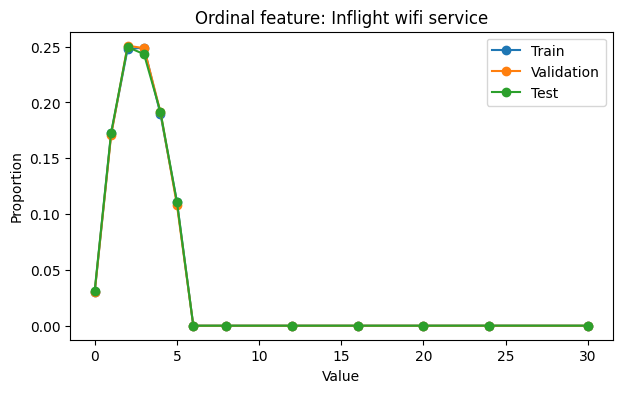

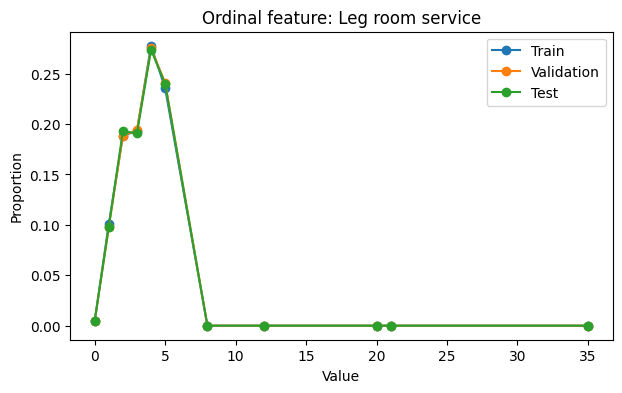

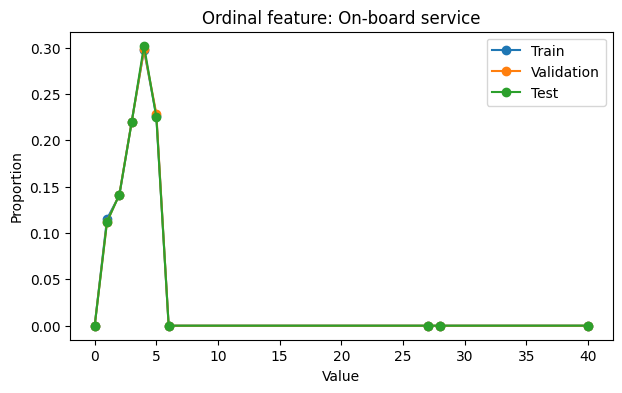

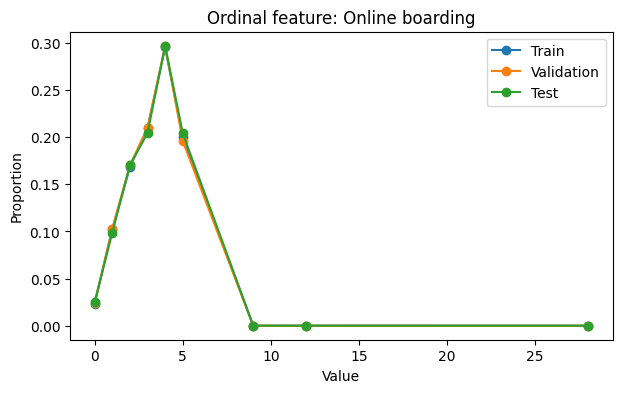

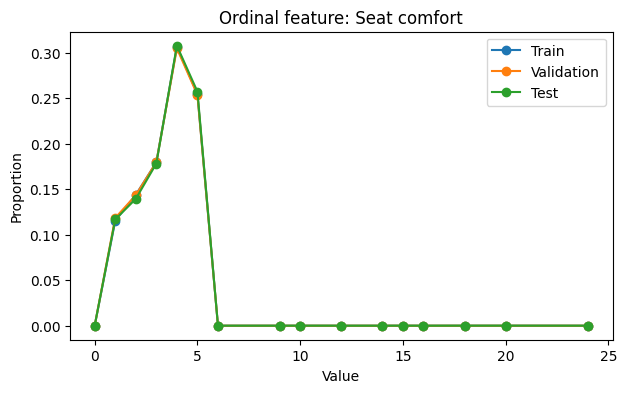

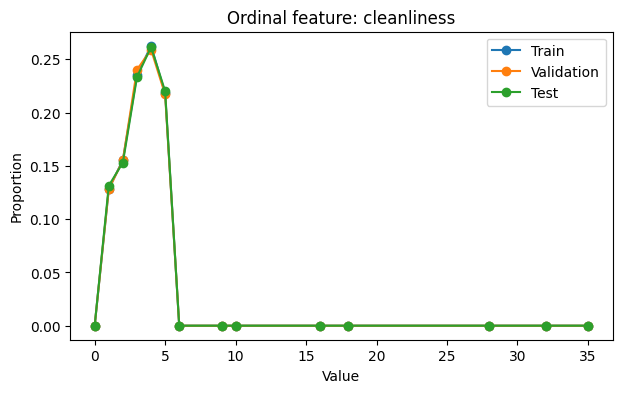

In [37]:
# Доли классов считаем только для train/val, т.к. test без разметки
target_dist = pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "val": y_val.value_counts(normalize=True),
}).fillna(0)

print(target_dist)




def plot_continuous_distributions(X_train, X_val, cols, X_test=None):
    for col in cols:
        plt.figure(figsize=(7,4))
        plt.hist(X_train[col], bins=30, alpha=0.5, density=True, label="Train")
        plt.hist(X_val[col], bins=30, alpha=0.5, density=True, label="Validation")
        if X_test is not None:
            plt.hist(X_test[col], bins=30, alpha=0.5, density=True, label="Test")
        plt.title(f"Continuous feature: {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.show()

plot_continuous_distributions(X_train, X_val, continuous_cols, X_test=df_test)


def plot_ordinal_distributions(X_train, X_val, cols, X_test=None):
    for col in sorted(cols):
        plt.figure(figsize=(7,4))

        tr = X_train[col].value_counts(normalize=True).sort_index()
        va = X_val[col].value_counts(normalize=True).sort_index()

        # совместим индексы (чтобы не "прыгали" точки)
        idx = sorted(set(tr.index) | set(va.index) | (set(X_test[col].unique()) if X_test is not None else set()))
        tr = tr.reindex(idx, fill_value=0)
        va = va.reindex(idx, fill_value=0)

        plt.plot(tr.index, tr.values, marker="o", label="Train")
        plt.plot(va.index, va.values, marker="o", label="Validation")

        if X_test is not None:
            te = X_test[col].value_counts(normalize=True).sort_index().reindex(idx, fill_value=0)
            plt.plot(te.index, te.values, marker="o", label="Test")

        plt.title(f"Ordinal feature: {col}")
        plt.xlabel("Value")
        plt.ylabel("Proportion")
        plt.legend()
        plt.show()

plot_ordinal_distributions(X_train, X_val, ordinal_cols, X_test=df_test)


В целом распределения похожи

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [38]:
# Сохраним исходные данные до лог-преобразования (для сравнения/графиков)
X_train_raw = X_train.copy()
X_val_raw = X_val.copy()
df_test_raw = df_test.copy()

# Логарифмическое преобразование задержек
# Используем log1p (log(x+1)), так как log(0) не определён

delay_cols = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']

for col in delay_cols:
    X_train[col] = np.log1p(X_train[col])
    X_val[col] = np.log1p(X_val[col])
    df_test[col] = np.log1p(df_test[col])

print("Логарифмическое преобразование применено к:")
print(delay_cols)
print("\nСтатистики после преобразования:")
print(X_train[delay_cols].describe())


Логарифмическое преобразование применено к:
['Departure Delay in Minutes', 'Arrival Delay in Minutes']

Статистики после преобразования:
       Departure Delay in Minutes  Arrival Delay in Minutes
count                71395.000000              71395.000000
mean                     1.223352                  1.245631
std                      1.600072                  1.609947
min                      0.000000                  0.000000
25%                      0.000000                  0.000000
50%                      0.000000                  0.000000
75%                      2.564949                  2.639057
max                      5.583496                  5.602119


Построение.

Континуальные признаки: RAW (до лог-преобразования)


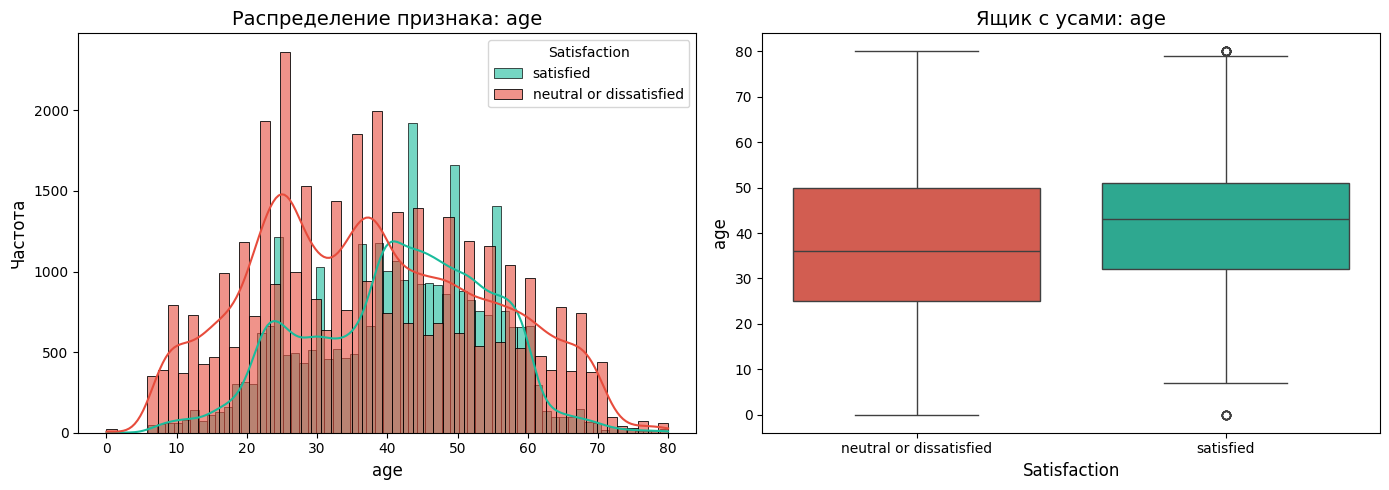

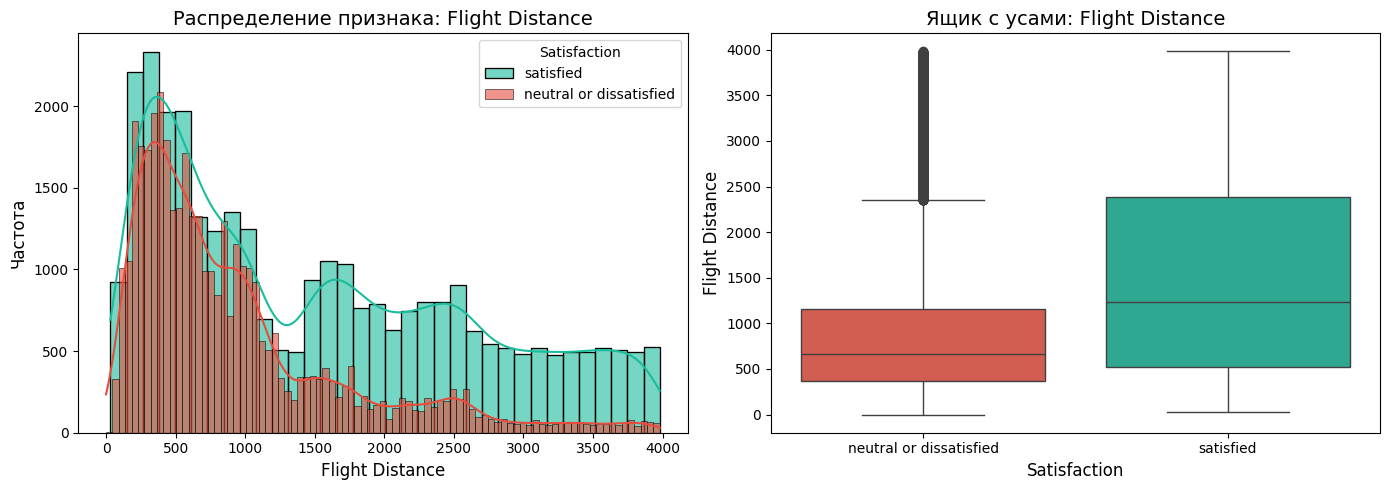

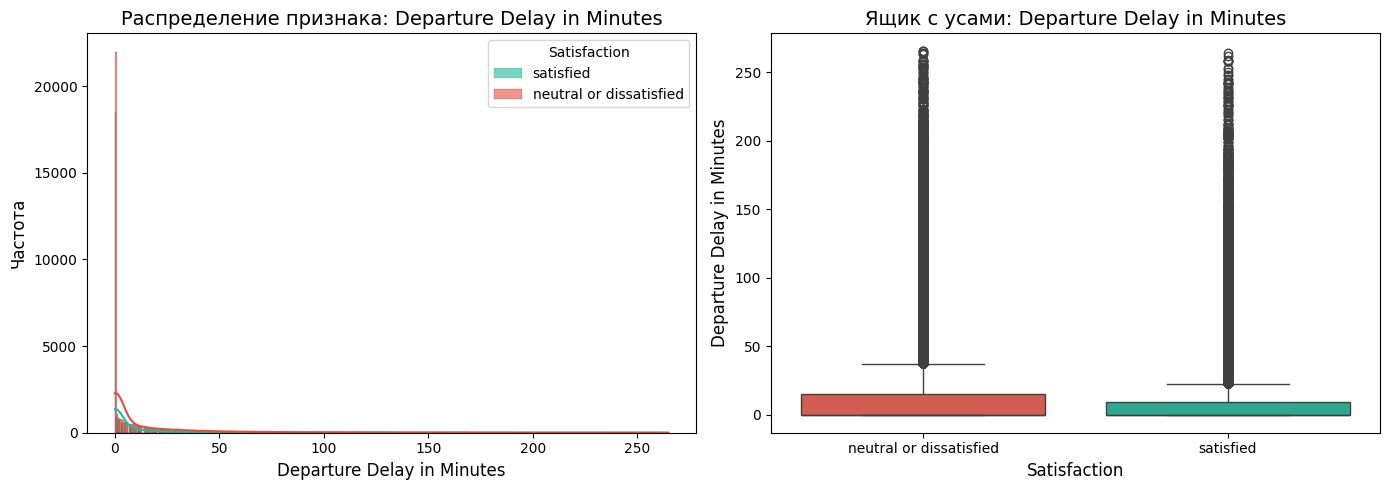

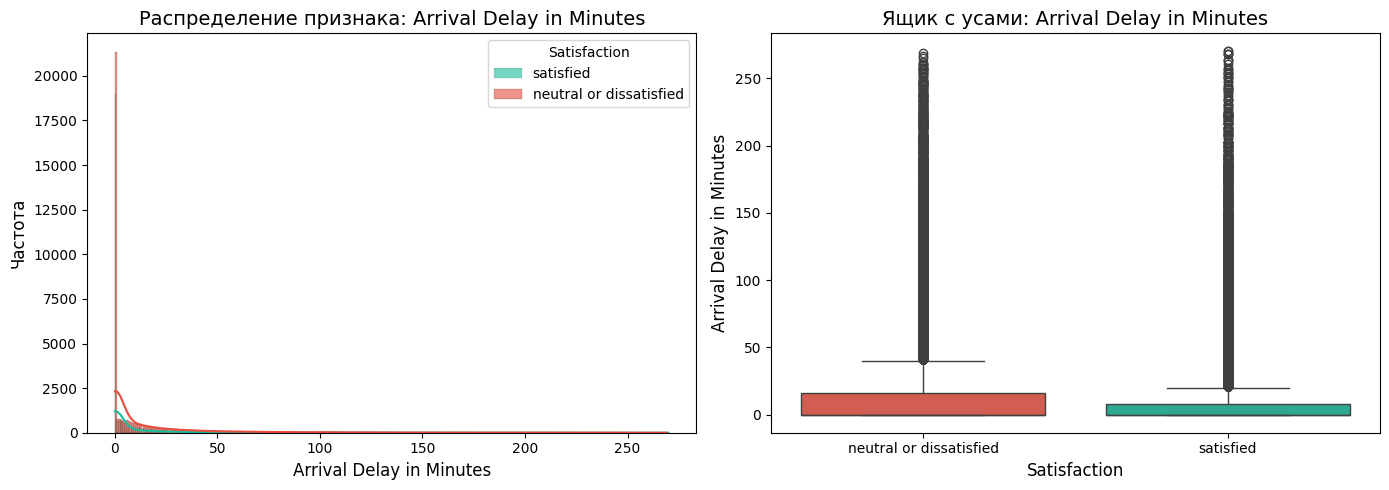

Континуальные признаки: LOG (после лог-преобразования)


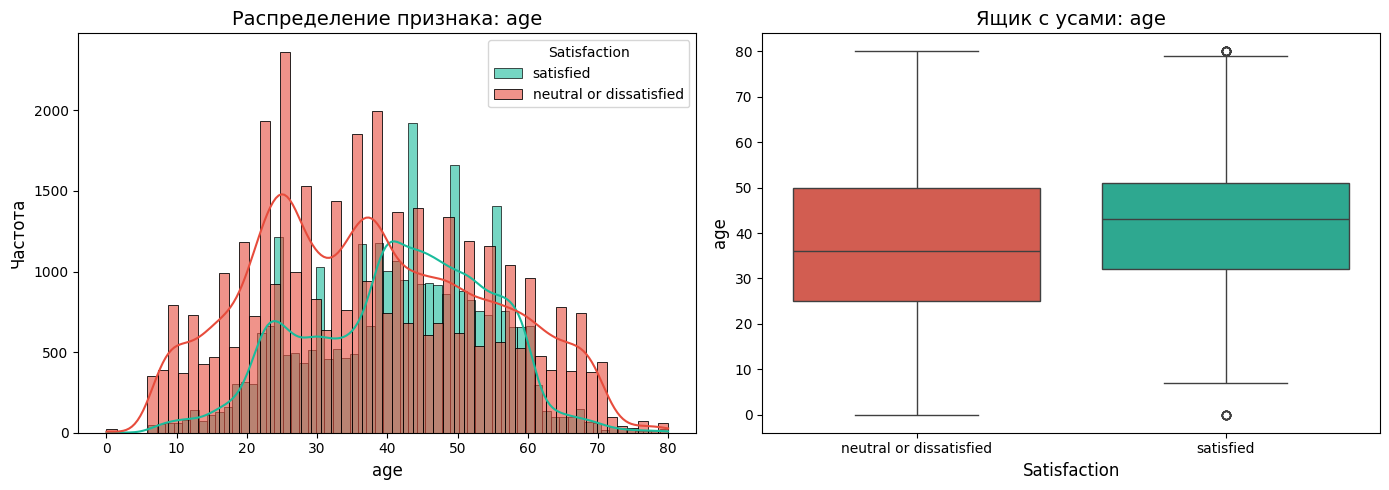

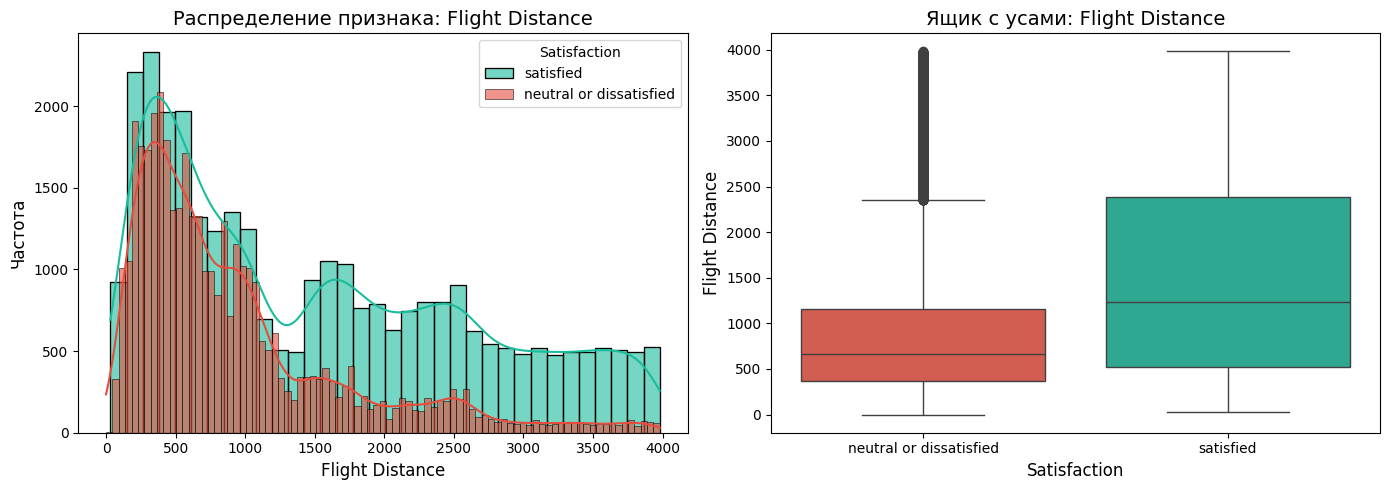

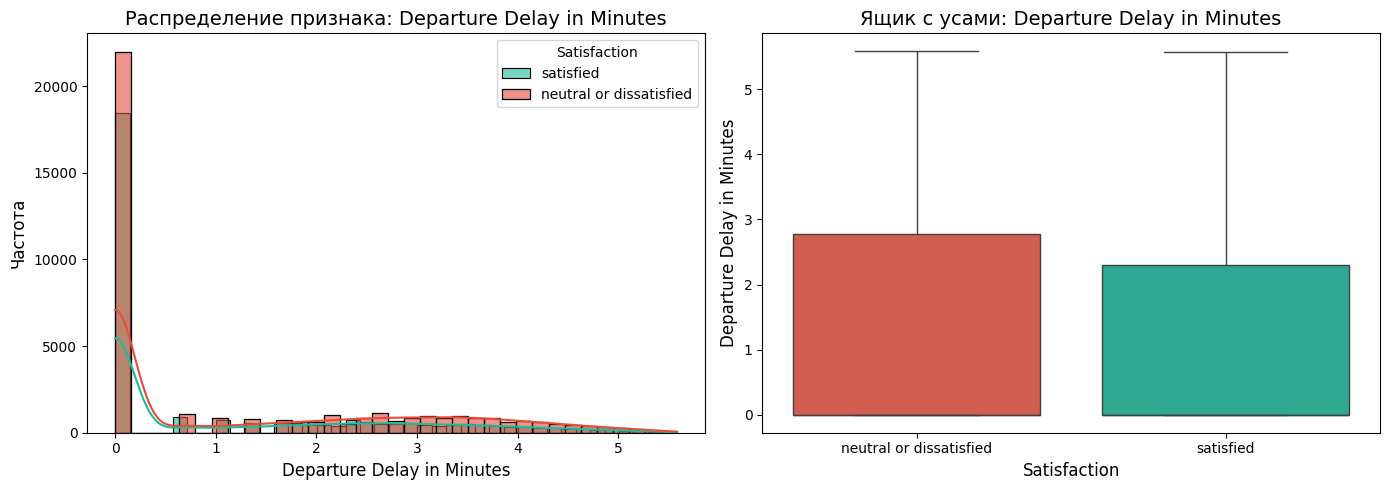

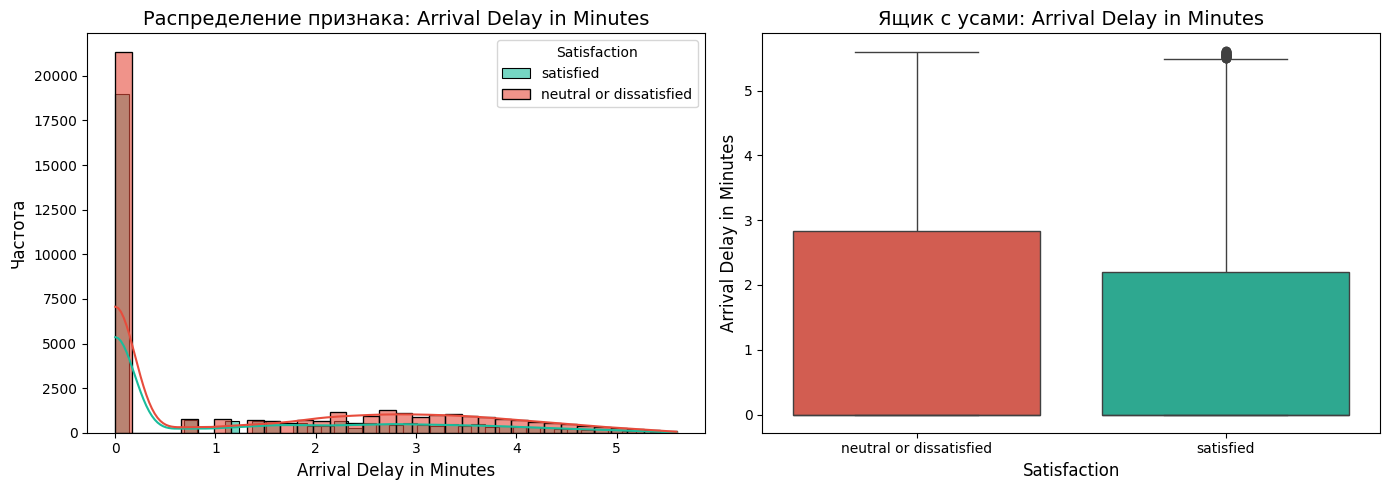

In [39]:
# Графики континуальных признаков (raw и log)
print("Континуальные признаки: RAW (до лог-преобразования)")
plot_continuous(continuous_cols, X_train_raw, y_train)

print("Континуальные признаки: LOG (после лог-преобразования)")
plot_continuous(continuous_cols, X_train, y_train)


**Вывод:**
преобразование уменьшило масштаб экстремальных значений и сделало распределения более "компактными".

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

**RAW (до лог‑преобразования)**


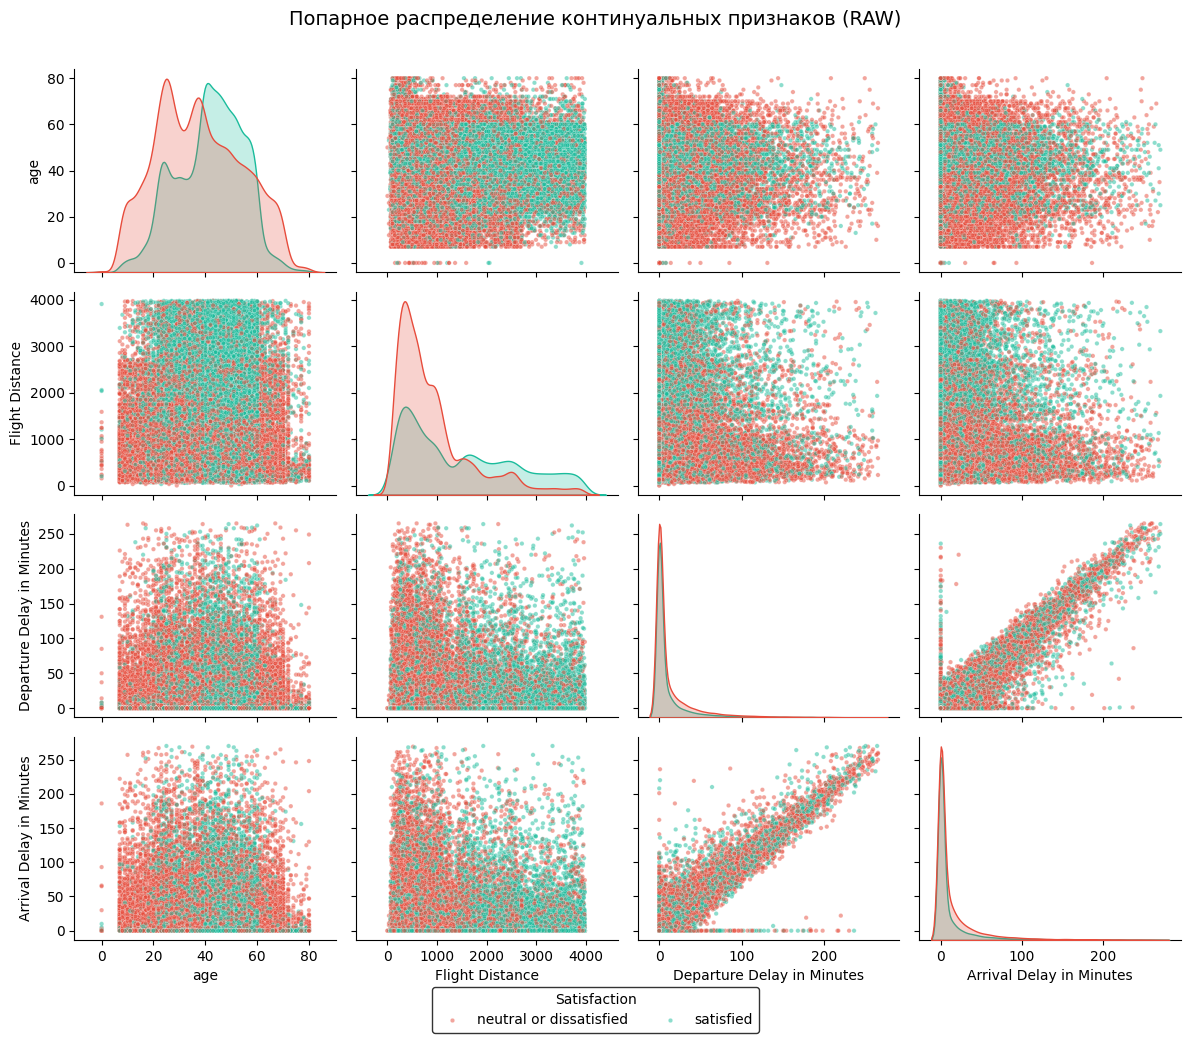

In [40]:
# Pairplot для континуальных признаков
palette = {'neutral or dissatisfied': '#e74c3c', 'satisfied': '#1abc9c'}

# Создаем датафрейм с континуальными признаками и таргетом
pairplot_df = X_train_raw[continuous_cols].copy()
pairplot_df['satisfaction'] = y_train.values

# Строим pairplot без встроенной легенды
g = sns.pairplot(pairplot_df, hue='satisfaction', palette=palette, 
                 diag_kind='kde', plot_kws={'alpha': 0.5, 's': 10})

# Удаляем старую легенду
g._legend.remove()

# Добавляем новую легенду снизу
g.figure.legend(handles=g._legend_data.values(), 
                labels=g._legend_data.keys(),
                loc='lower center', 
                ncol=2,
                title='Satisfaction',
                bbox_to_anchor=(0.5, -0.02),
                frameon=True,
                facecolor='white',
                edgecolor='black')

# Заголовок
g.figure.suptitle('Попарное распределение континуальных признаков (RAW)', y=1.01, fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()


**LOG (после лог‑преобразования)**


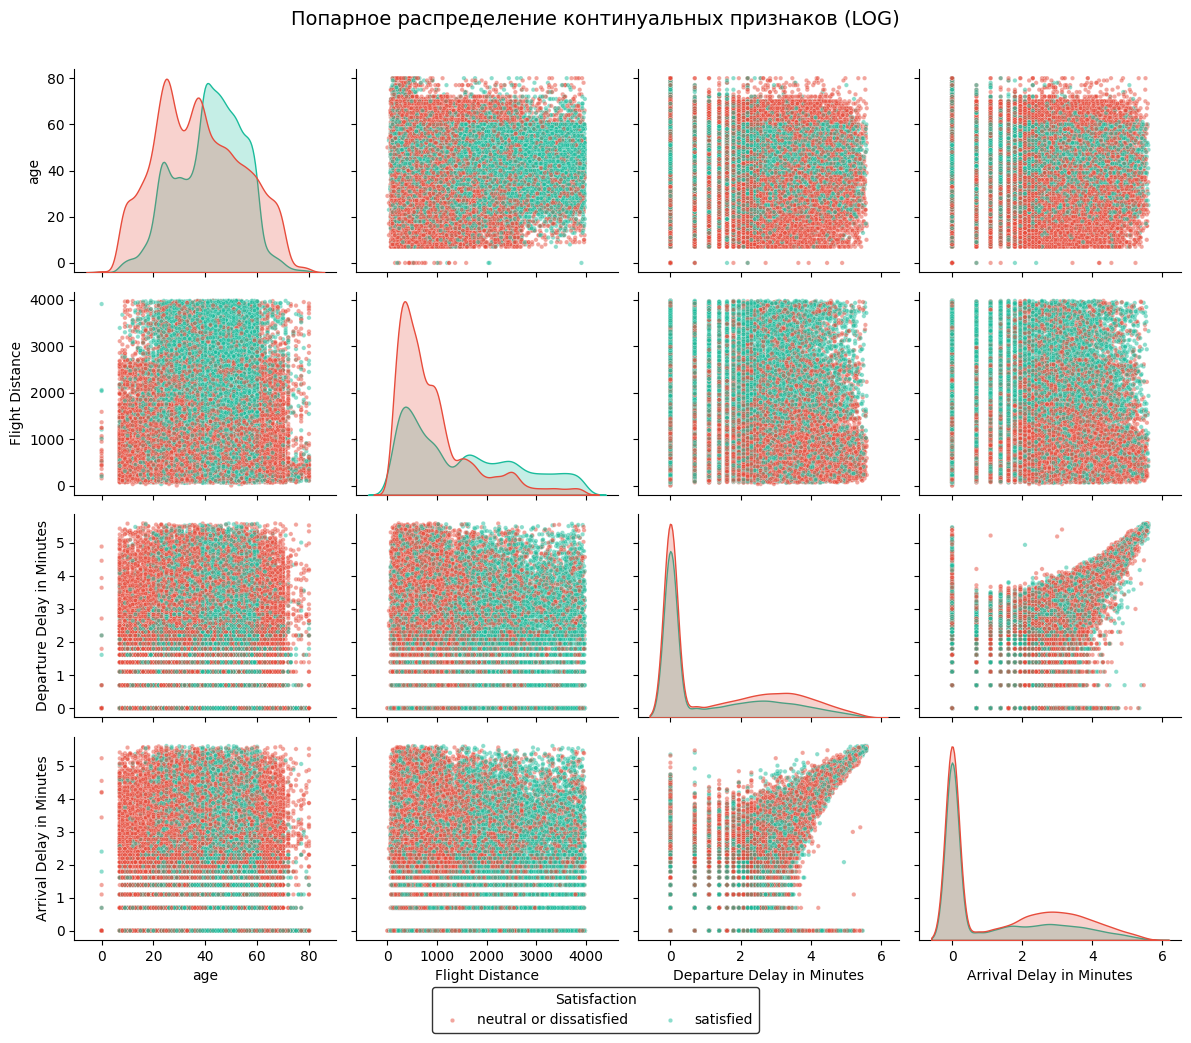

In [41]:
# Pairplot для континуальных признаков (LOG)
palette = {'neutral or dissatisfied': '#e74c3c', 'satisfied': '#1abc9c'}

pairplot_df = X_train[continuous_cols].copy()
pairplot_df['satisfaction'] = y_train.values

g = sns.pairplot(pairplot_df, hue='satisfaction', palette=palette, 
                 diag_kind='kde', plot_kws={'alpha': 0.5, 's': 10})

g._legend.remove()
g.figure.legend(handles=g._legend_data.values(), 
                labels=g._legend_data.keys(),
                loc='lower center', 
                ncol=2,
                title='Satisfaction',
                bbox_to_anchor=(0.5, -0.02),
                frameon=True,
                facecolor='white',
                edgecolor='black')

g.figure.suptitle('Попарное распределение континуальных признаков (LOG)', y=1.01, fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()


Pairplot показал, что признаки Departure Delay и Arrival Delay имеют сильную положительную корреляцию.  Flight Distance оказывает слабое влияние: удовлетворенные пассажиры немного чаще встречаются на дальних перелетах. Наиболее заметная связь с таргетом наблюдается у признаков задержек.

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [42]:
# Кодирование таргета: 'satisfied' -> 1, остальное -> 0
y_train_encoded = (y_train == 'satisfied').astype(int)
y_val_encoded = (y_val == 'satisfied').astype(int)

print("Кодирование таргета:")
print(f"Уникальные значения y_train_encoded: {y_train_encoded.unique()}")
print(f"Распределение: {y_train_encoded.value_counts().to_dict()}")
print()

# One-Hot Encoding для категориальных признаков
categorical_cols = ['gender', 'Customer Type', 'Type of Travel', 'class']

# Создаем encoder (совместимость со старыми версиями sklearn)
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')

# Обучаем на train
ohe.fit(X_train[categorical_cols])

# Получаем названия новых столбцов
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

# Применяем к train, val и test
X_train_ohe = pd.DataFrame(ohe.transform(X_train[categorical_cols]), 
                           columns=ohe_feature_names, index=X_train.index)
X_val_ohe = pd.DataFrame(ohe.transform(X_val[categorical_cols]), 
                         columns=ohe_feature_names, index=X_val.index)
df_test_ohe = pd.DataFrame(ohe.transform(df_test[categorical_cols]), 
                           columns=ohe_feature_names, index=df_test.index)

# Удаляем оригинальные категориальные столбцы и добавляем закодированные
X_train_final = pd.concat([X_train.drop(columns=categorical_cols), X_train_ohe], axis=1)
X_val_final = pd.concat([X_val.drop(columns=categorical_cols), X_val_ohe], axis=1)
df_test_final = pd.concat([df_test.drop(columns=categorical_cols), df_test_ohe], axis=1)

print("One-Hot Encoding применён:")
print(f"Размер X_train_final: {X_train_final.shape}")
print(f"Новые признаки: {list(ohe_feature_names)}")


Кодирование таргета:
Уникальные значения y_train_encoded: [0 1]
Распределение: {0: 40484, 1: 30911}

One-Hot Encoding применён:
Размер X_train_final: (71395, 26)
Новые признаки: ['gender_Male', 'Customer Type_disloyal Customer', 'Customer Type_nan', 'Type of Travel_Personal Travel', 'Type of Travel_nan', 'class_Eco', 'class_Eco Plus', 'class_nan']


### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [43]:
# Обучение дерева решений с параметрами по умолчанию
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train_final, y_train_encoded)

# Предсказание на валидации
y_val_pred = dt_default.predict(X_val_final)

# Accuracy score
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f"Accuracy на валидации: {accuracy:.4f}")


Accuracy на валидации: 0.9420


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [44]:
# Bias-Variance разложение для дерева решений
# Используем train как обучающую выборку, val как тестовую

error_dt, bias_dt, var_dt = bias_variance_decomp(
    dt_default,
    X_train_final.values,
    y_train_encoded.values,
    X_val_final.values,
    y_val_encoded.values,
    loss='0-1_loss',
    num_rounds=200,
    random_seed=42
)

print(f"Error: {error_dt:.4f}")
print(f"Bias: {bias_dt:.4f}")
print(f"Variance: {var_dt:.4f}")


Error: 0.0618
Bias: 0.0408
Variance: 0.0460


### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [45]:
# Структурные характеристики дерева
print(f"Глубина дерева: {dt_default.get_depth()}")
print(f"Количество листьев: {dt_default.get_n_leaves()}")


Глубина дерева: 31
Количество листьев: 2101


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

/var/folders/36/g8smjd3109dc79mqqyntkgpw0000gn/T/ipykernel_15256/2974538974.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_sorted.head(top_n), y=importances_sorted.head(top_n).index, palette='viridis')


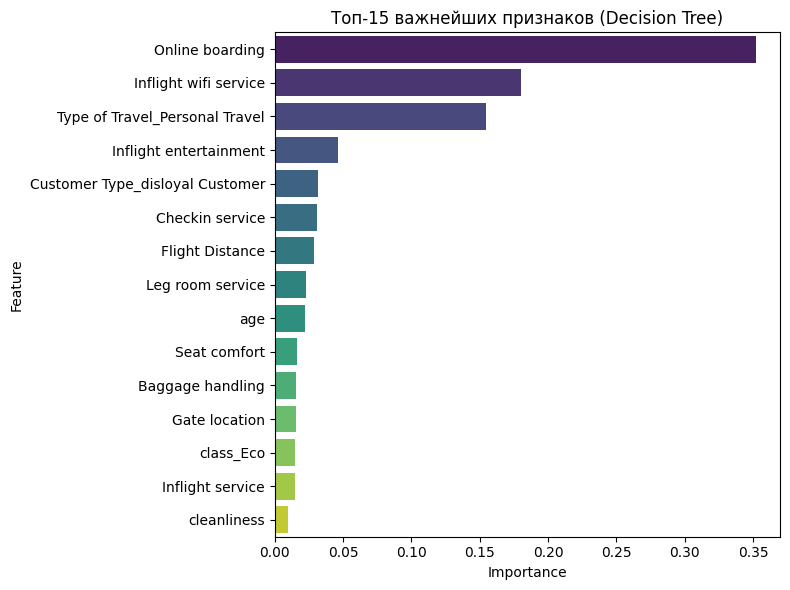

Наиболее информативные признаки: ['Online boarding', 'Inflight wifi service', 'Type of Travel_Personal Travel', 'Inflight entertainment', 'Customer Type_disloyal Customer']


In [46]:
# Важность признаков для дерева решений
importances = pd.Series(dt_default.feature_importances_, index=X_train_final.columns)
importances_sorted = importances.sort_values(ascending=False)

top_n = 15
plt.figure(figsize=(8, 6))
sns.barplot(x=importances_sorted.head(top_n), y=importances_sorted.head(top_n).index, palette='viridis')
plt.title(f'Топ-{top_n} важнейших признаков (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

top_features = list(importances_sorted.head(5).index)
print('Наиболее информативные признаки:', top_features)


### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [47]:
# Дерево глубины 5 по 2 наиболее информативным признакам
top2_features = top_features[:2]
print('Топ-2 признаки:', top2_features)

X_train_top2 = X_train_final[top2_features]
X_val_top2 = X_val_final[top2_features]

dt_top2 = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_top2.fit(X_train_top2, y_train_encoded)

y_val_pred_top2 = dt_top2.predict(X_val_top2)
acc_top2 = accuracy_score(y_val_encoded, y_val_pred_top2)
print(f'Accuracy на валидации (top-2, depth=5): {acc_top2:.4f}')


Топ-2 признаки: ['Online boarding', 'Inflight wifi service']
Accuracy на валидации (top-2, depth=5): 0.8248


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?


To reinstall 14.1.2, run:
  brew reinstall graphviz


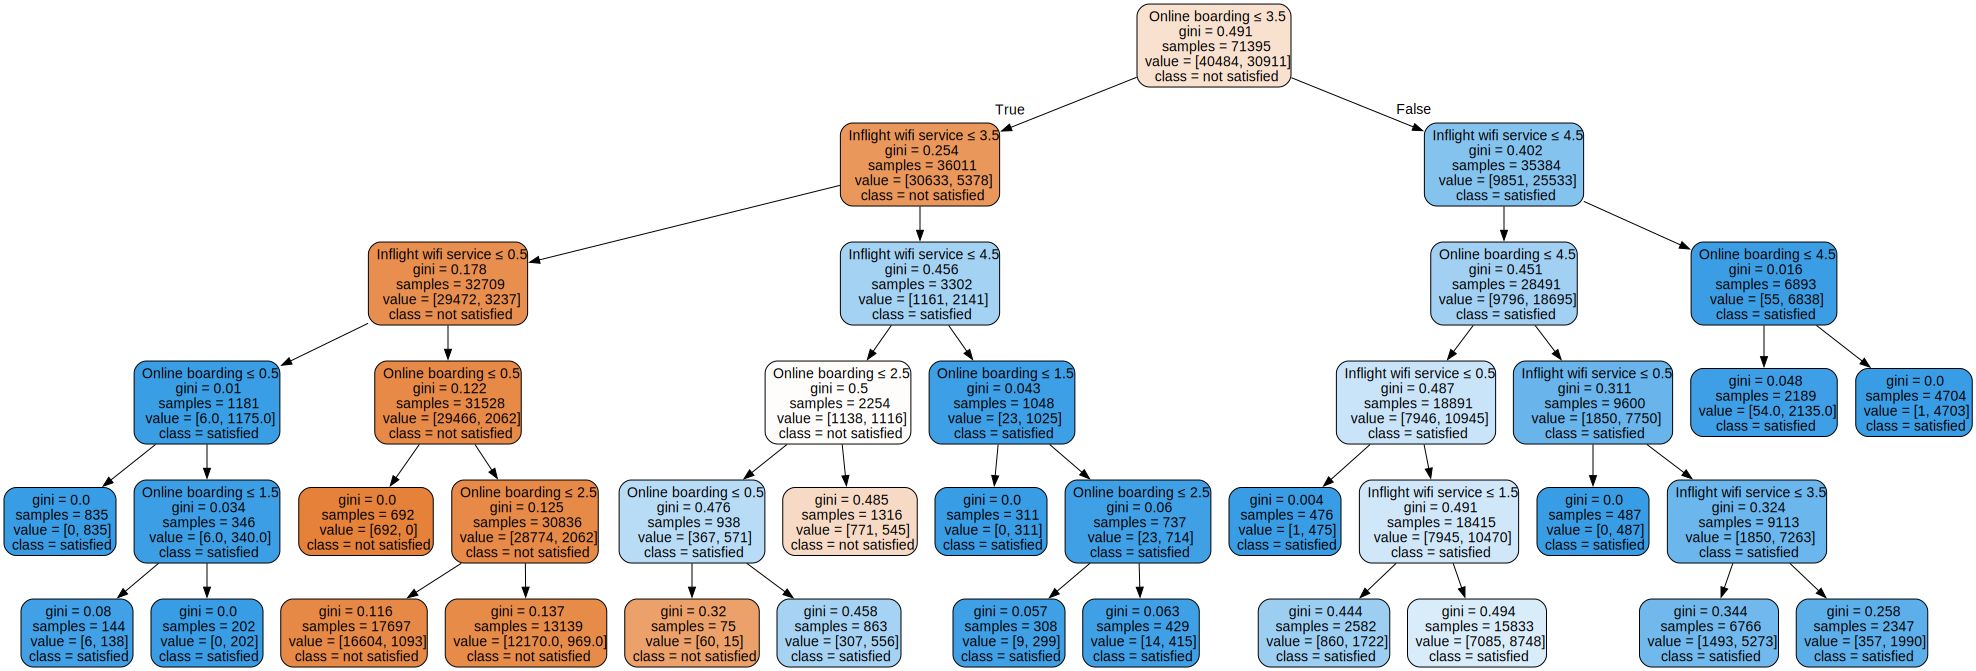

In [48]:
!brew install graphviz



# Визуализация дерева (топ-2 признаки) через graphviz
dot_data = export_graphviz(
    dt_top2,
    out_file=None,
    feature_names=top2_features,
    class_names=['not satisfied', 'satisfied'],
    filled=True,
    rounded=True,
    special_characters=True
)

Source(dot_data)


**Ответ:** пороги получаются кратными 0.5, потому что сплит в дереве идет по средниму значению между соседними значениями признака.
Если признак дискретный (например, оценки 1–5), то середина между 3 и 4 — это 3.5, поэтому в предикатах и видны дроби вида `x <= 3.5`.


### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

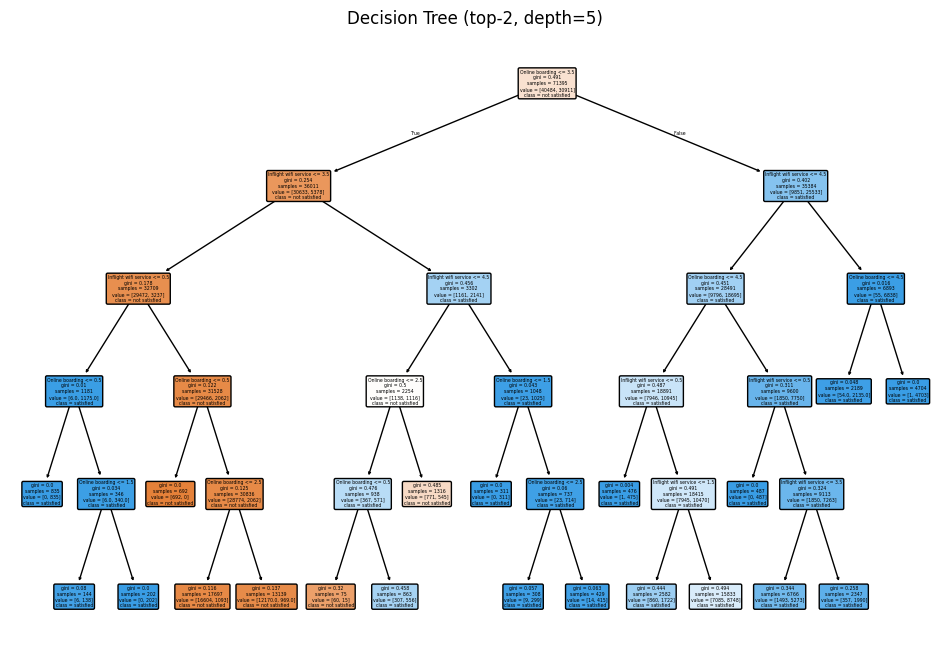

In [49]:
# Визуализация дерева через plot_tree
plt.figure(figsize=(12, 8))
plot_tree(
    dt_top2,
    feature_names=top2_features,
    class_names=['not satisfied', 'satisfied'],
    filled=True,
    rounded=True
)
plt.title('Decision Tree (top-2, depth=5)')
plt.show()


**Ответ:** дерево получилось несимметричным, потому что данные распределены неравномерно, и оптимальные разбиения глубже уточняют только одну из ветвей.


### **Задание 19. (0.5 балла)**

Используя функцию plot_decision_regions() из mlxtend, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/Users/slvic/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


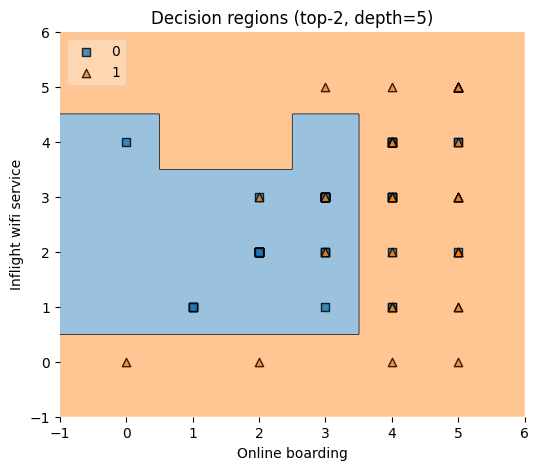

In [50]:
# Разделяющая поверхность дерева (top-2)
# Берём только первые 100 объектов обучающей выборки
X_plot = X_train_top2.iloc[:100].values
y_plot = y_train_encoded.iloc[:100].values

plt.figure(figsize=(6, 5))
plot_decision_regions(X=X_plot, y=y_plot, clf=dt_top2, legend=2)
plt.title('Decision regions (top-2, depth=5)')
plt.xlabel(top2_features[0])
plt.ylabel(top2_features[1])
plt.show()# Ваш код здесь

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

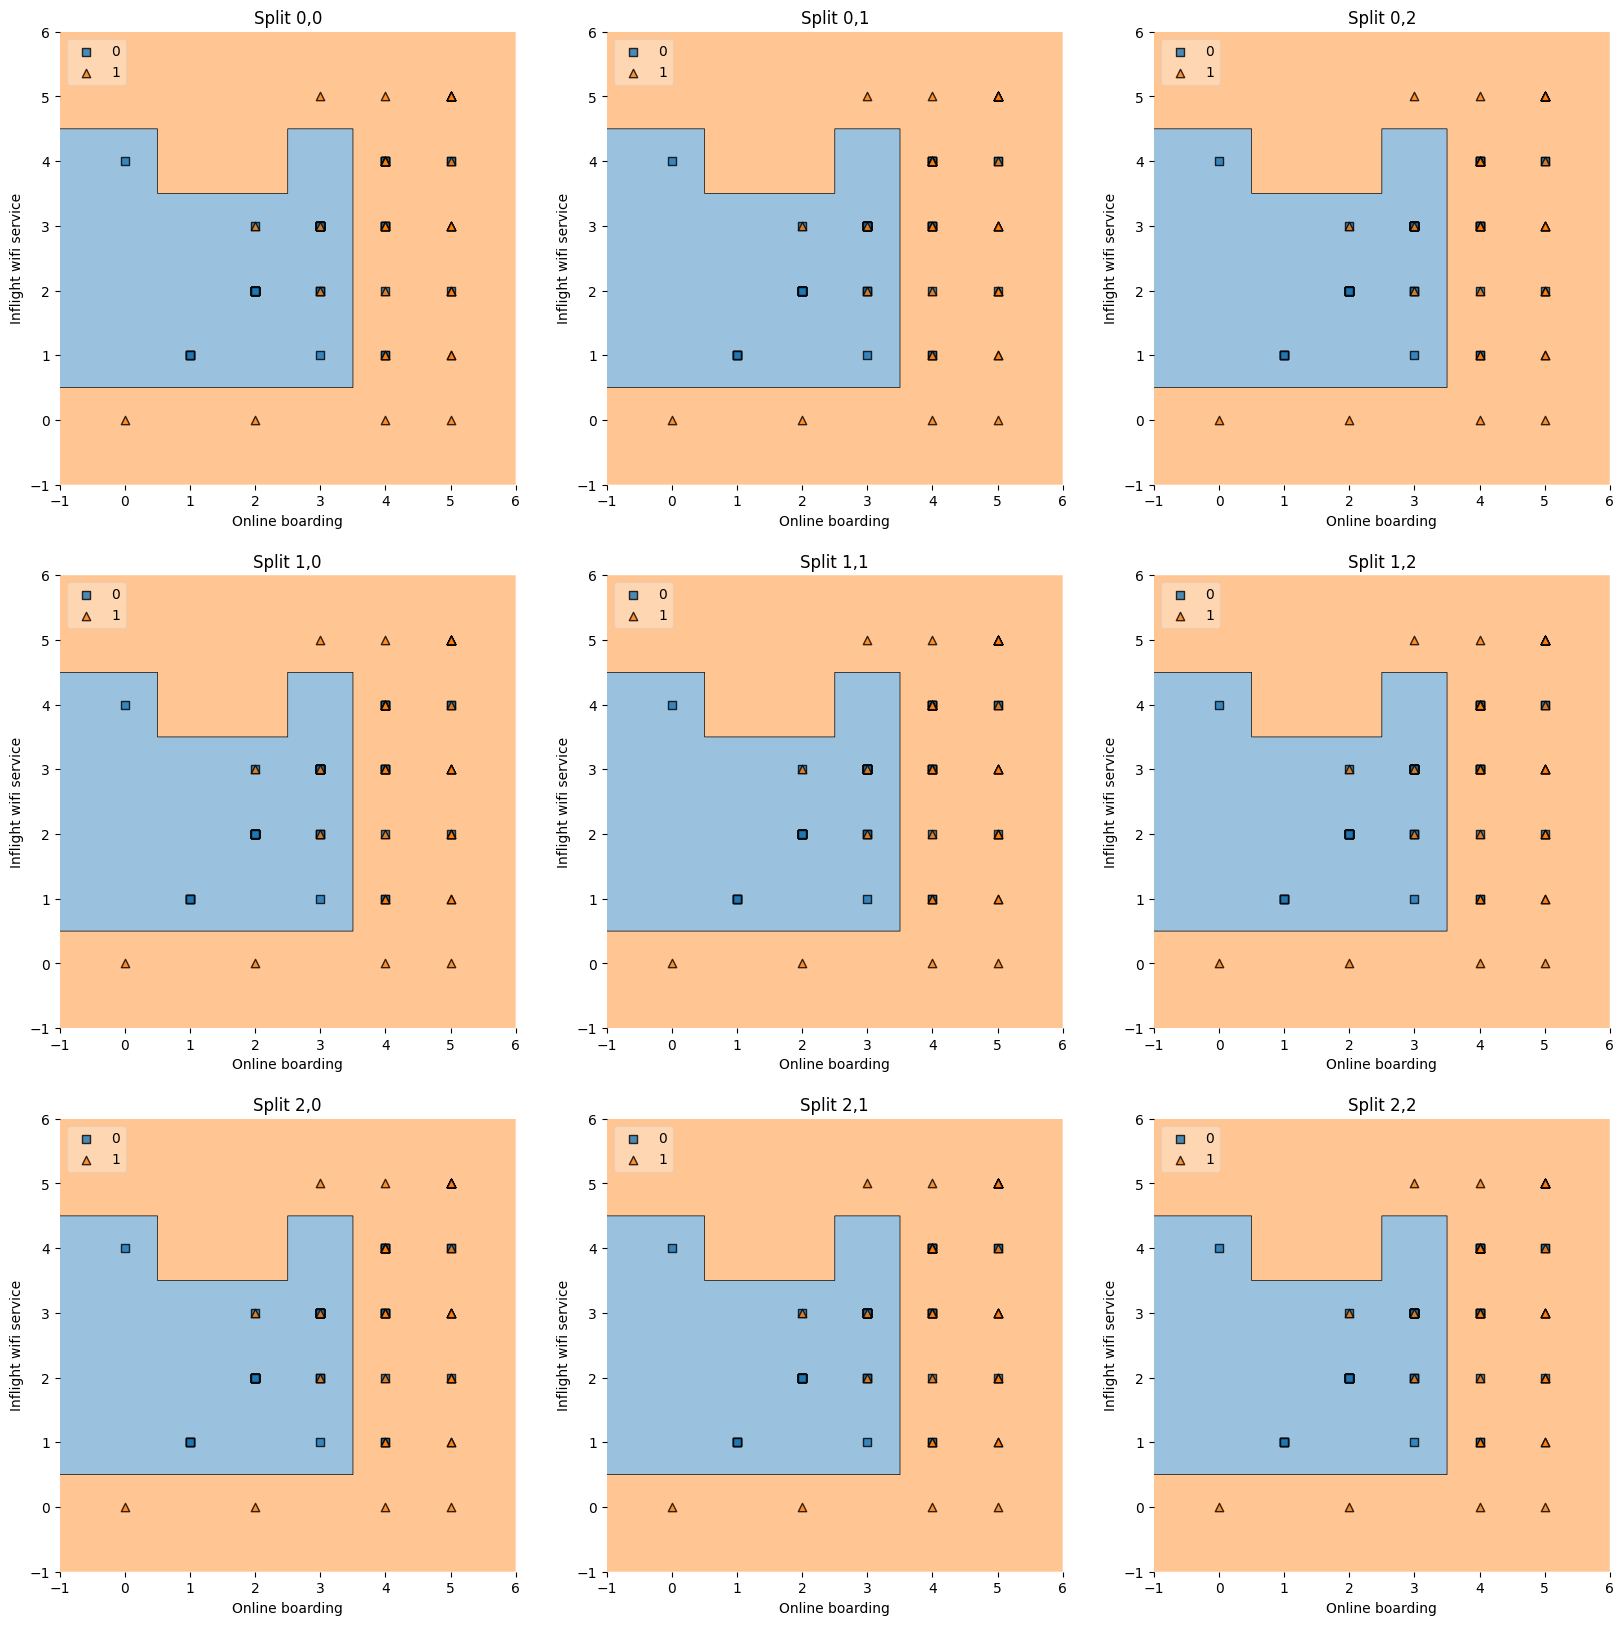

In [51]:
X_train_example = X_train_top2
y_train_example = y_train_encoded

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(len(X_train_example), size=len(X_train_example) - 20000, replace=False)

        X_fit = X_train_example.iloc[inds].values
        y_fit = y_train_example.iloc[inds].values

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_fit, y_fit)

        X_plot = X_train_example.iloc[:100].values
        y_plot = y_train_example.iloc[:100].values

        plot_decision_regions(clf=tree_exp, X=X_plot, y=y_plot, ax=ax[row][col], legend=2)

        ax[row][col].set_xlabel(top2_features[0])
        ax[row][col].set_ylabel(top2_features[1])
        ax[row][col].set_title(f"Split {row},{col}")




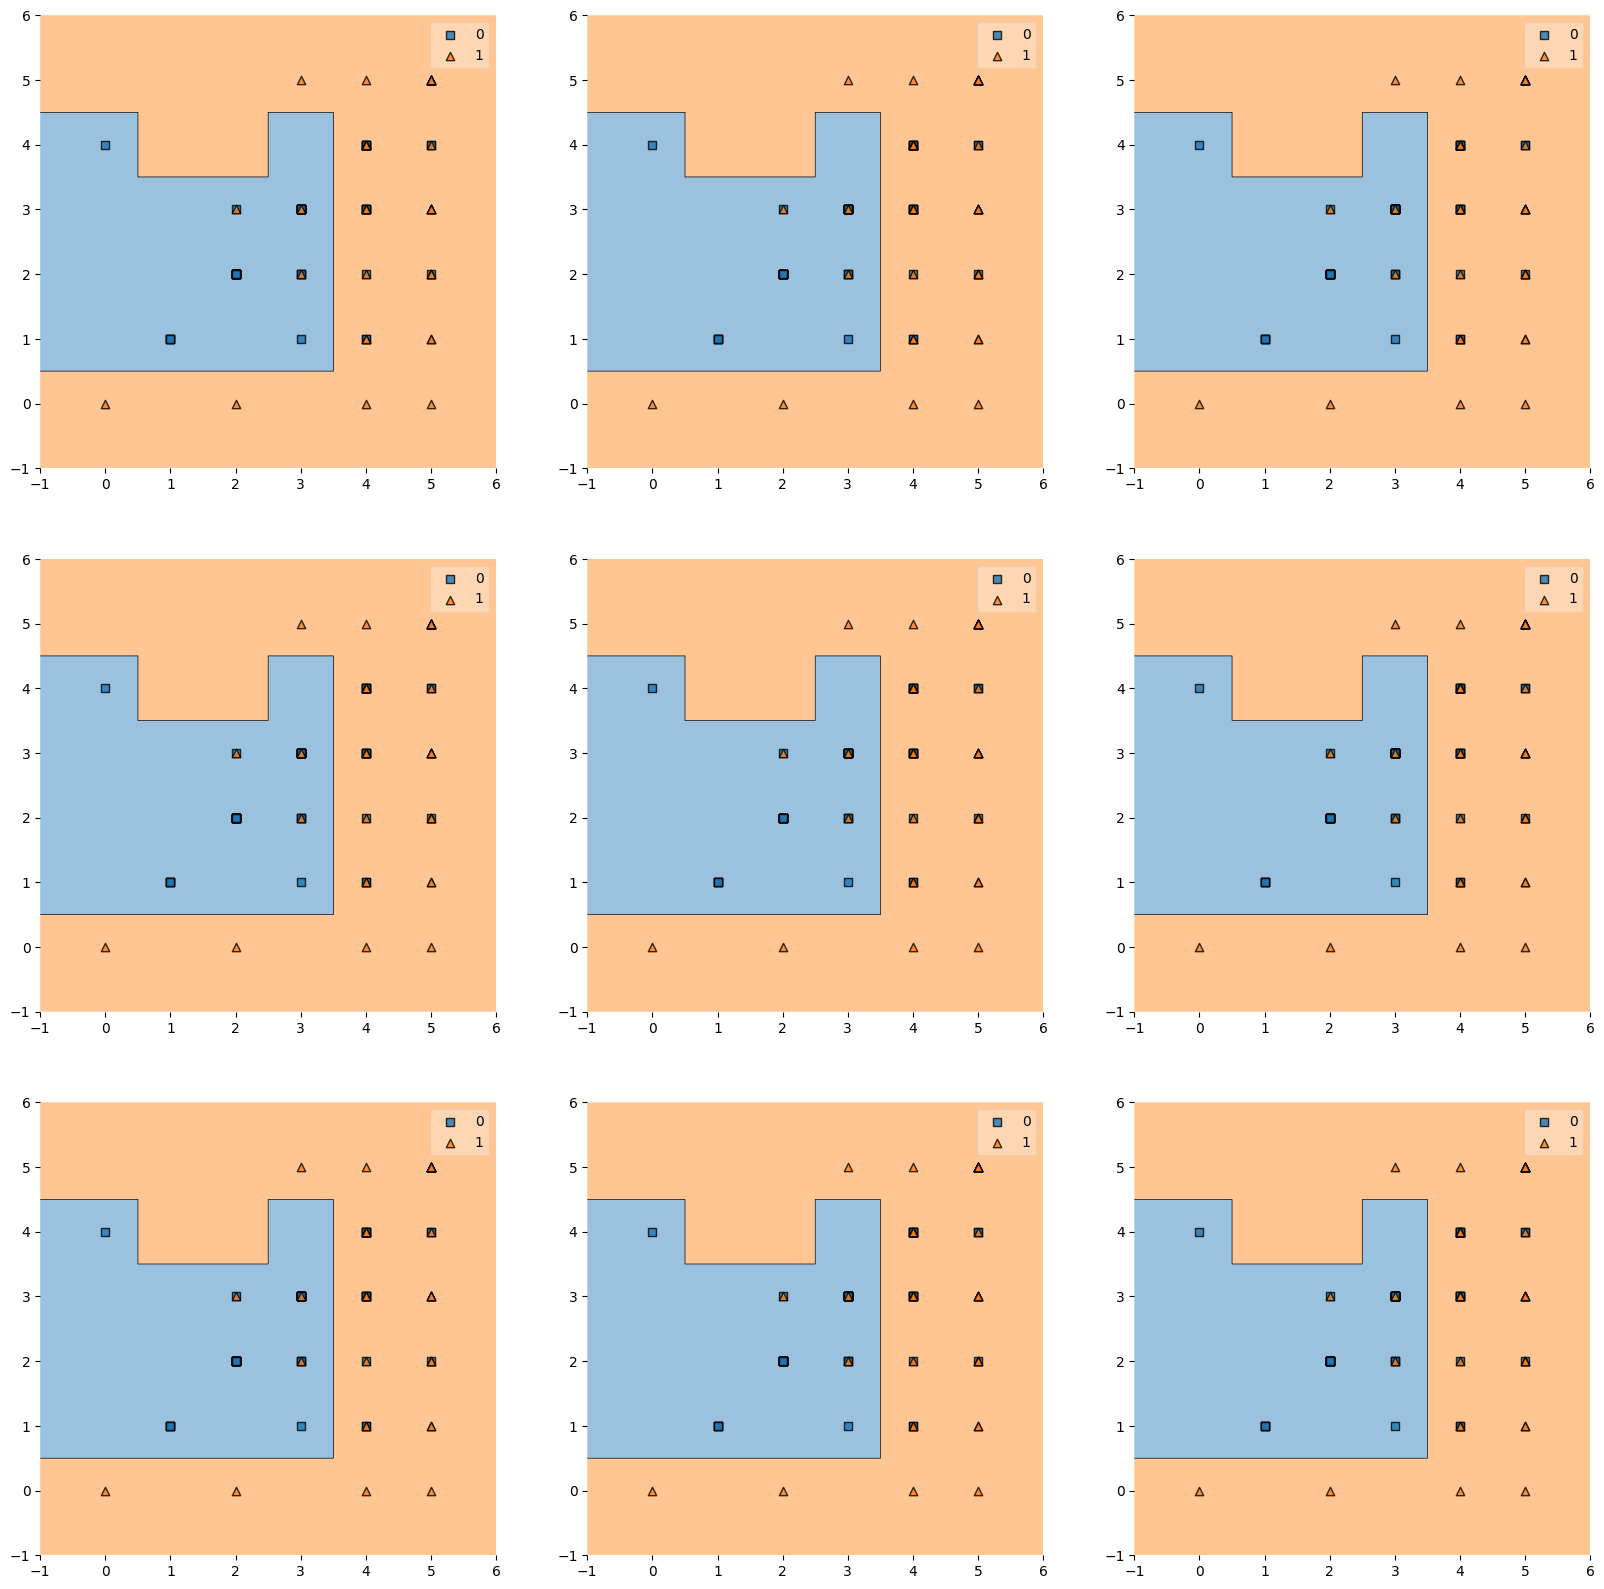

In [52]:
X_train_example = X_train_top2
y_train_example = y_train_encoded

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(len(X_train_example), size=len(X_train_example) - 1000, replace=False)

        X_fit = X_train_example.iloc[inds].values
        y_fit = y_train_example.iloc[inds].values

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_fit, y_fit)

        X_plot = X_train_example.iloc[:100].values
        y_plot = y_train_example.iloc[:100].values

        plot_decision_regions(clf=tree_exp, X=X_plot, y=y_plot, ax=ax[row][col])


**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [53]:
# Обучение DT на разных глубинах (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_final, y_train_encoded)
    y_predicted_train = DT.predict(X_train_final)
    y_predicted_val = DT.predict(X_val_final)
    accuracies_train.append(accuracy_score(y_train_encoded, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val_encoded, y_predicted_val))


CPU times: user 2.79 s, sys: 78.2 ms, total: 2.87 s
Wall time: 2.95 s


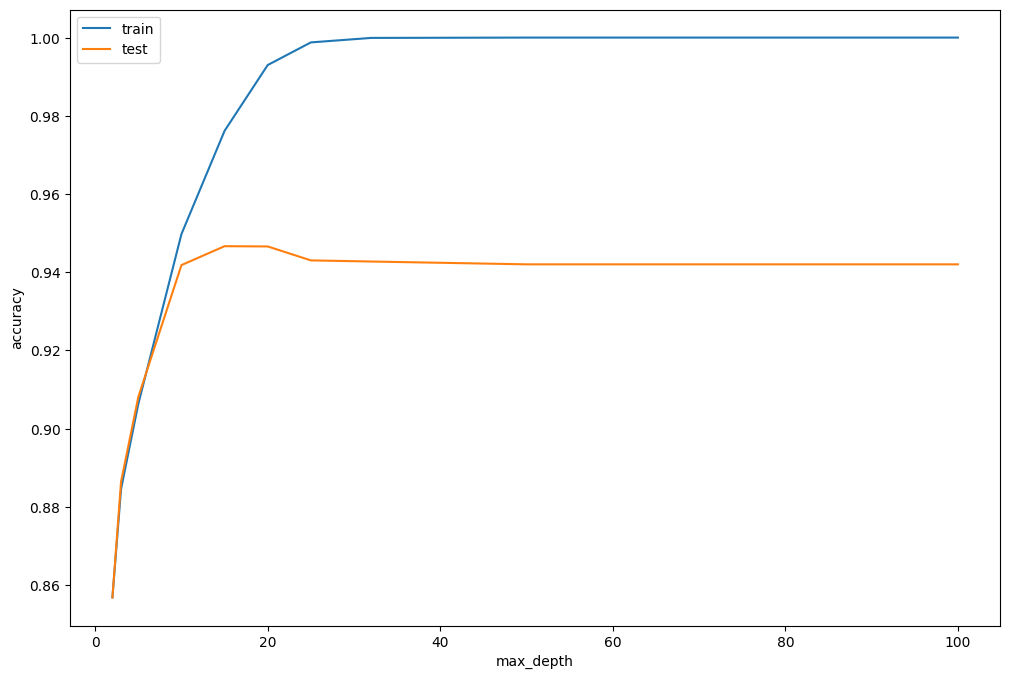

In [54]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [55]:
# Подбор гиперпараметров для Decision Tree (CV)
param_grid = {
    'max_depth': [3, 5, 8, 12, 16, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(dt, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_final, y_train_encoded)

print('Лучшие параметры:', grid.best_params_)
print(f'Лучший CV accuracy: {grid.best_score_:.4f}')

best_dt = grid.best_estimator_
y_val_pred_best = best_dt.predict(X_val_final)
acc_val_best = accuracy_score(y_val_encoded, y_val_pred_best)
print(f'Accuracy на валидации (best): {acc_val_best:.4f}')

# Для сравнения: baseline дерево по умолчанию
y_val_pred_base = dt_default.predict(X_val_final)
acc_val_base = accuracy_score(y_val_encoded, y_val_pred_base)
print(f'Accuracy на валидации (baseline): {acc_val_base:.4f}')


Лучшие параметры: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20}
Лучший CV accuracy: 0.9503
Accuracy на валидации (best): 0.9511
Accuracy на валидации (baseline): 0.9367


/Users/slvic/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


**Ответ:** сравните accuracy на валидации для baseline и лучшей модели. Если best > baseline — качество улучшилось.


# Сохранение лучшего дерева
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_dt, f)


In [56]:
with open('DT.pkl', 'wb') as f:
    pass

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [57]:
# Случайный лес по умолчанию + accuracy
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_final, y_train_encoded)

y_val_pred_rf = rf_default.predict(X_val_final)
acc_rf = accuracy_score(y_val_encoded, y_val_pred_rf)
print(f'Accuracy на валидации (RF default): {acc_rf:.4f}')


Accuracy на валидации (RF default): 0.9612


### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

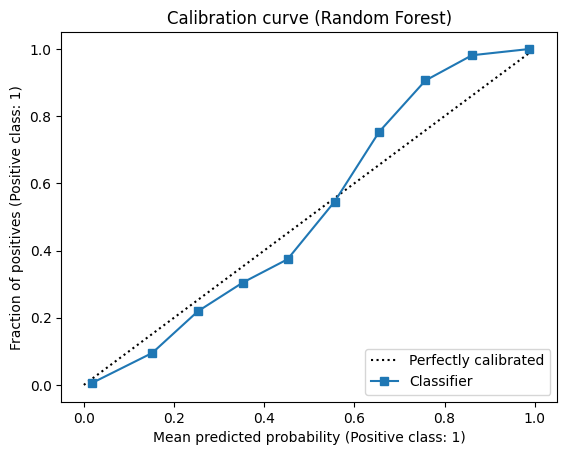

In [58]:
# Калибровочная кривая для случайного леса
y_val_proba_rf = rf_default.predict_proba(X_val_final)[:, 1]

disp = CalibrationDisplay.from_predictions(
    y_val_encoded,
    y_val_proba_rf,
    n_bins=10
)
plt.title('Calibration curve (Random Forest)')
plt.show()


Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

![image.png](attachment:5fdfd2ca-1969-4df9-833c-99a285e0f596.png)
![image.png](attachment:44aa9835-a7bf-46ce-bfce-c167aec0e0a6.png)

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [ ]:
# Логистическая регрессия (увеличим max_iter для сходимости)
log_reg = LogisticRegression(max_iter=2000, solver='liblinear')
log_reg.fit(X_train_final, y_train_encoded)

y_val_proba_lr = log_reg.predict_proba(X_val_final)[:, 1]

CalibrationDisplay.from_predictions(
    y_val_encoded,
    y_val_proba_lr,
    n_bins=10
)
plt.title('Calibration curve (Logistic Regression)')
plt.show()


Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

![image.png](attachment:fda8c488-1adb-4c87-ab70-8bd552c88e35.png)
![image.png](attachment:29e197f2-10b0-4819-9d1b-5c81525e64ed.png)

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
# Калибровка вероятностей RF (logistic и isotonic)
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_final, y_train_encoded)

# исходные вероятности
y_val_proba_rf = rf_default.predict_proba(X_val_final)[:, 1]

# логистическая калибровка (Platt)
logit_cal = LogisticRegression(max_iter=2000, solver='liblinear')
logit_cal.fit(y_val_proba_rf.reshape(-1, 1), y_val_encoded)
y_val_proba_logit = logit_cal.predict_proba(y_val_proba_rf.reshape(-1, 1))[:, 1]

# изотоническая калибровка
iso_cal = IsotonicRegression(out_of_bounds='clip')
iso_cal.fit(y_val_proba_rf, y_val_encoded)
y_val_proba_iso = iso_cal.transform(y_val_proba_rf)

fig, ax = plt.subplots(figsize=(6, 6))
CalibrationDisplay.from_predictions(y_val_encoded, y_val_proba_rf, n_bins=10, name='RF', ax=ax)
CalibrationDisplay.from_predictions(y_val_encoded, y_val_proba_logit, n_bins=10, name='RF + logistic', ax=ax)
CalibrationDisplay.from_predictions(y_val_encoded, y_val_proba_iso, n_bins=10, name='RF + isotonic', ax=ax)

# диагональ идеальной калибровки
ax.set_title('Calibration curves')
ax.legend()
plt.show()


**Интерпретация:** сравните три кривые с диагональю (идеальная калибровка). Чем ближе к диагонали, тем лучше.
Обычно логистическая калибровка сглаживает переуверенность, изотоническая может дать лучшую подгонку, но иногда переобучается на валидации.


***Вывод***

   - RF (синий) на высоких вероятностях чаще недооценивает (кривая выше диагонали).
   - RF + logistic (оранжевый) на высоких вероятностях переоценивает (overconfident), потому что кривая ниже диагонали, местами хуже даже исходного RF, особенно на высоких вероятностях.
   - RF + isotonic (зелёный) визуально ближе всего к диагонали почти на всем диапазоне — калибровка лучшая среди трех.
   - изотоническая калибровка дала наилучшее приближение к идеальной, логистическая здесь не улучшила калибровку, а RF остается некалиброванным.

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

Подходы к калибровке вероятностей:


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [77]:
# Bias-Variance разложение для случайного леса (до калибровки)
error_rf, bias_rf, var_rf = bias_variance_decomp(
    rf_default,
    X_train_final.values,
    y_train_encoded.values,
    X_val_final.values,
    y_val_encoded.values,
    loss='0-1_loss',
    num_rounds=200,
    random_seed=42
)

print(f"Error (RF): {error_rf:.4f}")
print(f"Bias (RF): {bias_rf:.4f}")
print(f"Variance (RF): {var_rf:.4f}")


Error (RF): 0.0403
Bias (RF): 0.0387
Variance (RF): 0.0090


**Ответы**
- Видно, что ошибка в целом снизилась. Если в дереве решений разброс (variance) равен 0.0460, в RF разброс снизился на до 0.0090.  снизилась степень переобученности. Незначительно снизилось смещение (bias) на  до 0.0408, те модель RF лучше определяет предсказания, которые соответствуют таргету.

```
Решающее дерево
Error: 0.0618
Bias: 0.0408
Variance: 0.0460
```

- Согласно теории

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [78]:
# Bias-Variance разложение для логистической регрессии (ванильной)
error_lr, bias_lr, var_lr = bias_variance_decomp(
    log_reg,
    X_train_final.values,
    y_train_encoded.values,
    X_val_final.values,
    y_val_encoded.values,
    loss='0-1_loss',
    num_rounds=200,
    random_seed=42
)

print(f"Error (LR): {error_lr:.4f}")
print(f"Bias (LR): {bias_lr:.4f}")
print(f"Variance (LR): {var_lr:.4f}")



Error (LR): 0.1241
Bias (LR): 0.1242
Variance (LR): 0.0042


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# Ваш код здесь


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


In [66]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

NameError: name 'X_train_enc' is not defined

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?